In [1109]:
import seaborn as sns
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import statsmodels.graphics.gofplots as sgg
from statsmodels.stats.anova import anova_lm
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from scipy.special import inv_boxcox 
import tensorflow as tf
keras = tf.keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from math import e
from Plot_Series_Difference import plot_series_and_difference
from LSTM_Windowize import windowize_data
from Coinbase_Data import fetch_daily_data
%matplotlib inline
plt.style.use('ggplot')

In [826]:
df_btc = pd.read_csv('data/BTC-USD.csv', header = 0)

In [827]:
df_bch = pd.read_csv('data/BCH-USD.csv', header = 0)

In [828]:
df_bnb = pd.read_csv('data/BNB-USD.csv', header = 0)

In [829]:
df_bsv = pd.read_csv('data/BSV-USD.csv', header = 0)

In [830]:
df_eos = pd.read_csv('data/EOS-USD.csv', header = 0)

In [831]:
df_eth = pd.read_csv('data/ETH-USD.csv', header = 0)

In [832]:
df_ltc = pd.read_csv('data/LTC-USD.csv', header = 0)

In [833]:
df_xrp = pd.read_csv('data/XRP-USD.csv', header = 0)

In [834]:
df_xtz = pd.read_csv('data/XTZ-USD.csv', header = 0)

In [835]:
#investigate/inspect df_btc
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2310 non-null   object 
 1   Open       2310 non-null   float64
 2   High       2310 non-null   float64
 3   Low        2310 non-null   float64
 4   Close      2310 non-null   float64
 5   Adj Close  2310 non-null   float64
 6   Volume     2310 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 126.5+ KB


In [836]:
df_btc.head()

Date        Open        High         Low       Close   Adj Close  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100

In [837]:
df_btc.tail()

Date          Open          High           Low         Close  \
2305  2021-01-08  39381.765625  41946.738281  36838.636719  40797.609375   
2306  2021-01-09  40788.640625  41436.351563  38980.875000  40254.546875   
2307  2021-01-10  40254.218750  41420.191406  35984.628906  38356.441406   
2308  2021-01-11  38346.531250  38346.531250  30549.599609  35566.656250   
2309  2021-01-12  35447.621094  36513.601563  32791.082031  34501.832031   

         Adj Close        Volume  
2305  40797.609375   88107519479  
2306  40254.546875   61984162837  
2307  38356.441406   79980747690  
2308  35566.656250  123320567398  
2309  34501.832031   79853420544

[]

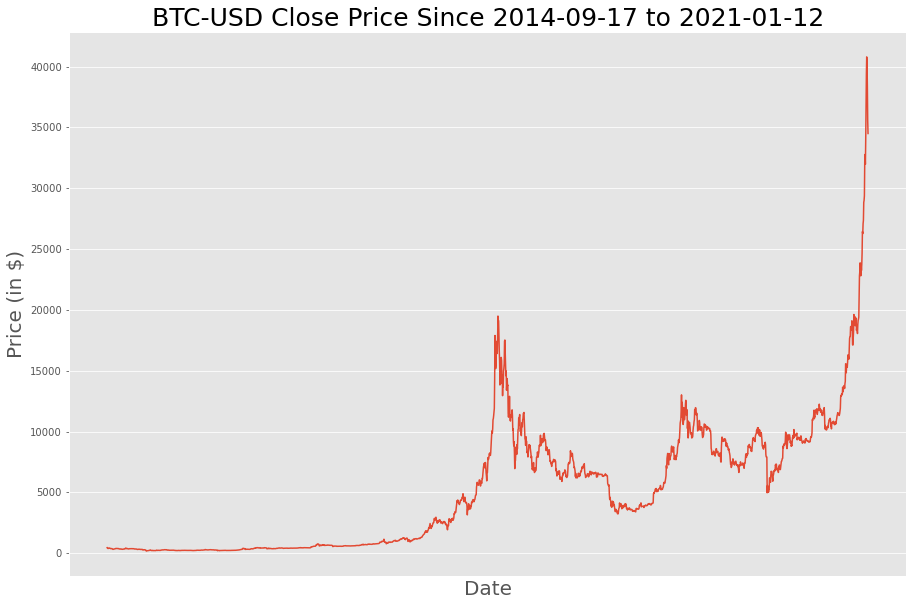

In [838]:
#plot BTC-USD 'Close' price over its' lifetime
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(df_btc['Date'], df_btc['Close'])
end_date = df_btc['Date'][(len(df_btc)-1)]
init_date = df_btc['Date'][0]
ax.set_title(f'BTC-USD Close Price Since {init_date} to {end_date}', fontsize = 25) 
ax.set_xlabel('Date', fontsize = 20) 
ax.set_ylabel('Price (in $)', fontsize = 20)
ax.set_xticks([])

In [839]:
df_btc['Volume_Price'] = df_btc['Close'] * df_btc['Volume'] 
#Volume_Price is the product of Volume and Price 
#for a specific date

In [840]:
df_btc['10_Day_VWAP'] = float('NaN')

In [841]:
for i in range(10, len(df_btc) + 1):
    df_btc['10_Day_VWAP'][i-1] = np.sum(df_btc['Volume_Price'][i-10:i])/np.sum(df_btc['Volume'][i-10:i])
#10-day VWAP is the sum of Volume*Price for each specific day 
#for the past 10 days divided by the 
#sum of Volume for the past 10 days

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [842]:
df_btc['Daily_Return'] = float('NaN')

In [843]:
for i in range(1, len(df_btc)):
    df_btc['Daily_Return'][i] = df_btc['Close'][i]/df_btc['Close'][i-1] - 1
#Daily Return is the percent gain/loss each day 
#compared to the previous day

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [844]:
df_btc['Biweekly_RS'] = float('NaN')

In [845]:
df_btc['Biweekly_RSI'] = float('NaN')

In [846]:
for i in range(13, len(df_btc)):
    daily_gain = 0
    daily_loss = 0
    for j in range(i-13, i+1):
        if df_btc['Daily_Return'][j] >= 0:
            daily_gain += df_btc['Daily_Return'][j]
        else:
            daily_loss += np.abs(df_btc['Daily_Return'][j])
    df_btc['Biweekly_RS'][i] = daily_gain/daily_loss
    daily_gain = 0
    daily_loss = 0
#RS = (Average of Upward Price Change/Average of Downward Price Change)
#the absolute value of the downward price change is applied 
#to the Average of the Downward Price Change 
#to ensure a positive value for RS always

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [847]:
for i in range(13, len(df_btc)):
    df_btc['Biweekly_RSI'][i] = 100 - (100/(1 + df_btc['Biweekly_RS'][i]))
#RSI = 100 – [100/(1 + RS)]
#for Biweekly RSI, the past 14 days are taken into account
#the absolute value of the downward price change is applied 
#to the Average of the Downward Price Change

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [848]:
df_btc['12_day_EMA'] = float('NaN')
df_btc['26_day_EMA'] = float('NaN')

In [849]:
for i in range(25, len(df_btc)):
    k_12 = 2/(12+1)
    k_26 = 2/(26+1)
    if i == 25:
        df_btc['12_day_EMA'][i] = np.sum(df_btc['Close'][i-11:i+1])/12
        df_btc['26_day_EMA'][i] = np.sum(df_btc['Close'][i-25:i+1])/26
    else:
        df_btc['12_day_EMA'][i] = df_btc['Close'][i] * k_12 + df_btc['12_day_EMA'][i-1] * (1 - k_12)
        df_btc['26_day_EMA'][i] = df_btc['Close'][i] * k_26 + df_btc['12_day_EMA'][i-1] * (1 - k_26)
#12-day EMA - 26-day EMA = MACD
#After calculating basic 12-day MA and 26-day MA for 
#initial calculations, 
#subsequent calculations of EMA consist of 
#Price(today) * k + EMA(yesterday) * (1 - k), 
#with k = 2/(N + 1) and N = # of days in EMA = 12
#For 26-day EMA, N = 26 instead

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykerne

In [850]:
df_btc['MACD'] = df_btc['12_day_EMA'] - df_btc['26_day_EMA']
#Moving Average Convergence/Divergence is simply the 
#difference between the 12-day EMA and 26-day EMA

In [851]:
df_btc['Signal'] = float('NaN')

In [852]:
for i in range(33, len(df_btc)):
    k_9 = 2/(9+1)
    if i == 33:
        df_btc['Signal'][i] = np.sum(df_btc['MACD'][i-8:i+1])/9
    else:
        df_btc['Signal'][i] = df_btc['MACD'][i] * k_9 + df_btc['MACD'][i-1] * (1 - k_9)
#Signal line is 9-day EMA
#the initial Signal line calculation is a
#simple moving average (SMA) for past 9 days

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [853]:
df_btc['Trend_Analysis_Close'] = float('NaN')

In [854]:
for i in range(3, len(df_btc)):
    if df_btc['Close'][i] > df_btc['Close'][i-2] and df_btc['Close'][i-1] > df_btc['Close'][i-3]:
        df_btc['Trend_Analysis_Close'][i] = 'UPTREND'
    elif df_btc['Close'][i] < df_btc['Close'][i-2] and df_btc['Close'][i-1] < df_btc['Close'][i-3]:
        df_btc['Trend_Analysis_Close'][i] = 'DOWNTREND'
    else:
        df_btc['Trend_Analysis_Close'][i] = 'N/A'
#simple trend analysis of just Close price

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/jonathon/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home

In [855]:
#further inspection of df's in preparation for first model
len(df_btc)

2310

In [856]:
df_bch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1270 non-null   object 
 1   Open       1270 non-null   float64
 2   High       1270 non-null   float64
 3   Low        1270 non-null   float64
 4   Close      1270 non-null   float64
 5   Adj Close  1270 non-null   float64
 6   Volume     1270 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.6+ KB


In [857]:
df_bnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1268 non-null   object 
 1   Open       1268 non-null   float64
 2   High       1268 non-null   float64
 3   Low        1268 non-null   float64
 4   Close      1268 non-null   float64
 5   Adj Close  1268 non-null   float64
 6   Volume     1268 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.5+ KB


In [858]:
df_bsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       221 non-null    float64
 2   High       221 non-null    float64
 3   Low        221 non-null    float64
 4   Close      221 non-null    float64
 5   Adj Close  221 non-null    float64
 6   Volume     221 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.9+ KB


In [859]:
df_eos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292 entries, 0 to 1291
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1292 non-null   object 
 1   Open       1292 non-null   float64
 2   High       1292 non-null   float64
 3   Low        1292 non-null   float64
 4   Close      1292 non-null   float64
 5   Adj Close  1292 non-null   float64
 6   Volume     1292 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 70.8+ KB


In [860]:
df_eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1986 non-null   object 
 1   Open       1986 non-null   float64
 2   High       1986 non-null   float64
 3   Low        1986 non-null   float64
 4   Close      1986 non-null   float64
 5   Adj Close  1986 non-null   float64
 6   Volume     1986 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 108.7+ KB


In [861]:
df_ltc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2310 non-null   object 
 1   Open       2310 non-null   float64
 2   High       2310 non-null   float64
 3   Low        2310 non-null   float64
 4   Close      2310 non-null   float64
 5   Adj Close  2310 non-null   float64
 6   Volume     2310 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 126.5+ KB


In [862]:
df_xrp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2310 non-null   object 
 1   Open       2310 non-null   float64
 2   High       2310 non-null   float64
 3   Low        2310 non-null   float64
 4   Close      2310 non-null   float64
 5   Adj Close  2310 non-null   float64
 6   Volume     2310 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 126.5+ KB


In [863]:
df_xtz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       238 non-null    float64
 2   High       238 non-null    float64
 3   Low        238 non-null    float64
 4   Close      238 non-null    float64
 5   Adj Close  238 non-null    float64
 6   Volume     238 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.9+ KB


In [864]:
pd.to_datetime(df_btc['Date'], infer_datetime_format = True)
pd.to_datetime(df_bch['Date'], infer_datetime_format = True)
pd.to_datetime(df_bnb['Date'], infer_datetime_format = True)
pd.to_datetime(df_bsv['Date'], infer_datetime_format = True)
pd.to_datetime(df_eos['Date'], infer_datetime_format = True)
pd.to_datetime(df_eth['Date'], infer_datetime_format = True)
pd.to_datetime(df_ltc['Date'], infer_datetime_format = True)
pd.to_datetime(df_xrp['Date'], infer_datetime_format = True)
pd.to_datetime(df_xtz['Date'], infer_datetime_format = True)

0     2020-05-07
1     2020-05-08
2     2020-05-09
3     2020-05-10
4     2020-05-11
         ...    
246   2021-01-08
247   2021-01-09
248   2021-01-10
249   2021-01-11
250   2021-01-12
Name: Date, Length: 251, dtype: datetime64[ns]

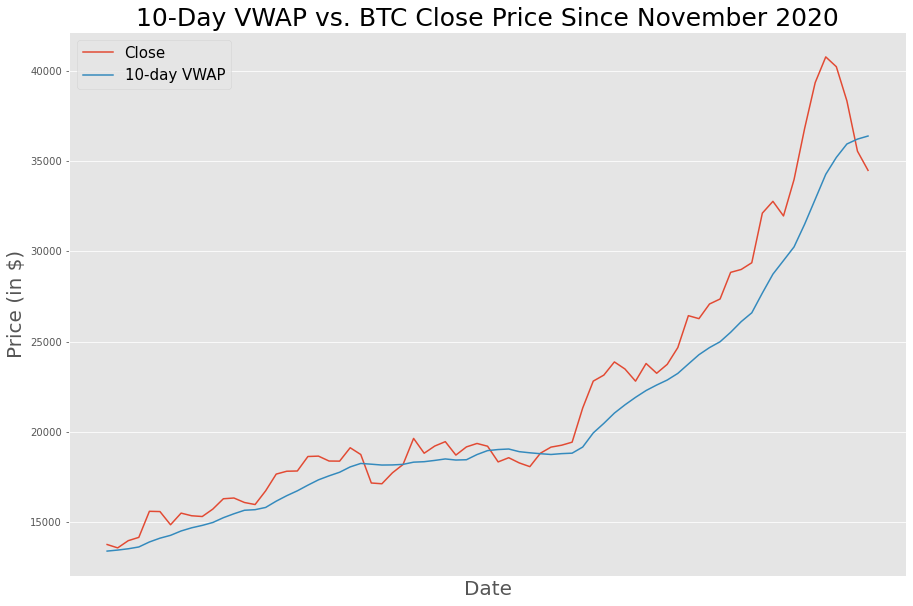

In [865]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(df_btc[df_btc['Date'] >= '2020-11-01']['Date'], df_btc[df_btc['Date'] >= '2020-11-01']['Close'], label = 'Close')
ax.plot(df_btc[df_btc['Date'] >= '2020-11-01']['Date'], df_btc[df_btc['Date'] >= '2020-11-01']['10_Day_VWAP'], label = '10-day VWAP')
ax.set_title('10-Day VWAP vs. BTC Close Price Since November 2020', fontsize = 25) 
ax.set_xlabel('Date', fontsize = 20) 
ax.set_ylabel('Price (in $)', fontsize = 20)
ax.set_xticks([])
ax.legend(fontsize = 15)

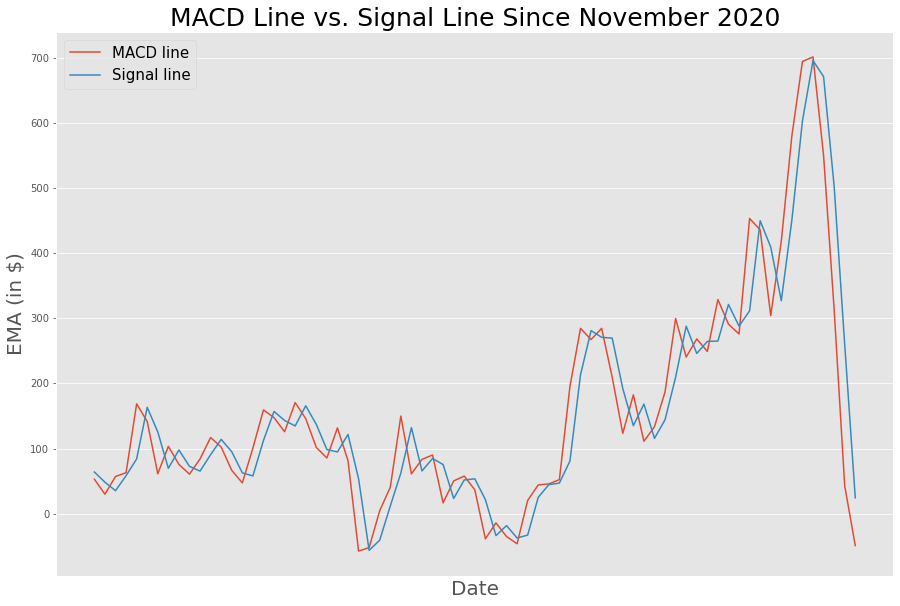

In [866]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(df_btc[df_btc['Date'] >= '2020-11-01']['Date'], df_btc[df_btc['Date'] >= '2020-11-01']['MACD'], label = 'MACD line')
ax.plot(df_btc[df_btc['Date'] >= '2020-11-01']['Date'], df_btc[df_btc['Date'] >= '2020-11-01']['Signal'], label = 'Signal line')
ax.set_title('MACD Line vs. Signal Line Since November 2020', fontsize = 25) 
ax.set_xlabel('Date', fontsize = 20) 
ax.set_ylabel('EMA (in $)', fontsize = 20)
ax.set_xticks([])
ax.legend(fontsize = 15)

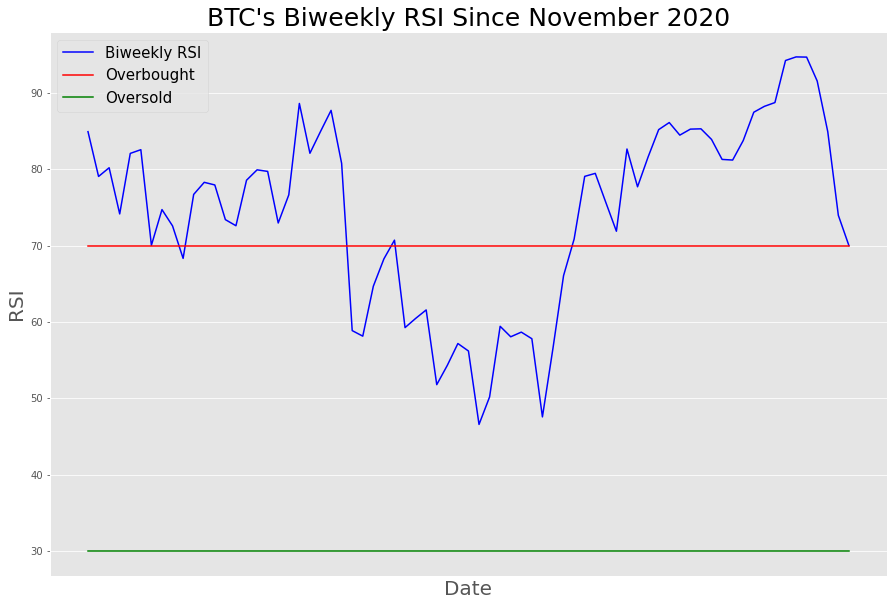

In [867]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(df_btc[df_btc['Date'] >= '2020-11-01']['Date'], df_btc[df_btc['Date'] >= '2020-11-01']['Biweekly_RSI'], label = 'Biweekly RSI', color = 'blue')
ax.plot(df_btc[df_btc['Date'] >= '2020-11-01']['Date'], [70] * len(df_btc[df_btc['Date'] >= '2020-11-01']), color = 'red', label = 'Overbought')
ax.plot(df_btc[df_btc['Date'] >= '2020-11-01']['Date'], [30] * len(df_btc[df_btc['Date'] >= '2020-11-01']), color = 'green', label = 'Oversold')
ax.set_title('BTC\'s Biweekly RSI Since November 2020', fontsize = 25) 
ax.set_xlabel('Date', fontsize = 20) 
ax.set_ylabel('RSI', fontsize = 20)
ax.set_xticks([])
ax.legend(fontsize = 15)

In [868]:
df_hist = df_btc[df_btc['Date'] >= '2020-03-01'][['Date', 'Daily_Return']]

In [869]:
max_df = df_hist['Daily_Return'].max()

In [870]:
min_df = df_hist['Daily_Return'].min()

In [871]:
bins = int((max_df - min_df)/0.01)

In [872]:
df_hist['Daily_Return_Perc'] = df_hist['Daily_Return'] * 100

Text(0, 0.5, 'Count')

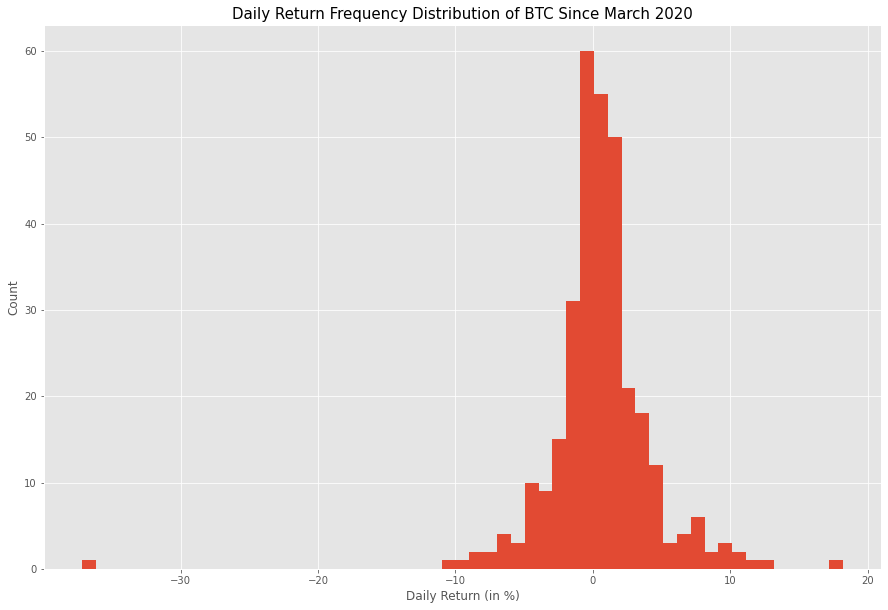

In [873]:
df_hist.hist(column = 'Daily_Return_Perc', bins = bins, figsize = (15, 10))
plt.title('Daily Return Frequency Distribution of BTC Since March 2020', fontsize = 15)
plt.xlabel('Daily Return (in %)')
plt.ylabel('Count')

In [874]:
len(df_hist)

318

In [875]:
#at 99% confidence, 3rd value in from greatest loss; at 95% confidence, 15th value in from greatest loss

In [878]:
df_hist.sort_values('Daily_Return_Perc').head(15)

Date  Daily_Return  Daily_Return_Perc
2003  2020-03-12     -0.371695         -37.169539
2178  2020-09-03     -0.102395         -10.239476
1999  2020-03-08     -0.089993          -8.999349
2062  2020-05-10     -0.087292          -8.729152
2262  2020-11-26     -0.084427          -8.442707
2308  2021-01-11     -0.072733          -7.273316
2007  2020-03-16     -0.070069          -7.006916
2005  2020-03-14     -0.065306          -6.530553
2085  2020-06-02     -0.062698          -6.269775
2146  2020-08-02     -0.060034          -6.003427
2032  2020-04-10     -0.059791          -5.979058
2013  2020-03-22     -0.057366          -5.736584
2094  2020-06-11     -0.055553          -5.555301
2020  2020-03-29     -0.051288          -5.128820
2307  2021-01-10     -0.047153          -4.715257

In [879]:
#Historical VaR
# -8% to -9% loss at 99% confidence, -4% to -5% at 95% confidence based on this time interval from February 1, 2020

In [880]:
df_btc.set_index('Date', drop = True, inplace = True)
df_bch.set_index('Date', drop = True, inplace = True)
df_bnb.set_index('Date', drop = True, inplace = True)
df_bsv.set_index('Date', drop = True, inplace = True)
df_eos.set_index('Date', drop = True, inplace = True)
df_eth.set_index('Date', drop = True, inplace = True)
df_ltc.set_index('Date', drop = True, inplace = True)
df_xrp.set_index('Date', drop = True, inplace = True)
df_xtz.set_index('Date', drop = True, inplace = True)

In [881]:
df_corr = pd.concat([df_btc['Close'], df_bch['Close'], df_bnb['Close'], df_bsv['Close'], 
                     df_eos['Close'], df_eth['Close'], df_ltc['Close'], df_xrp['Close'], df_xtz['Close']], 
                     keys = ['Close_BTC', 'Close_BCH', 'Close_BNB', 'Close_BSV', 'Close_EOS', 'Close_ETH', 'Close_LTC', 
                              'Close_XRP', 'Close_XTZ'], axis = 1)

In [882]:
df_corr[['Close_BCH_lag_1', 'Close_BNB_lag_1', 'Close_BSV_lag_1', 'Close_EOS_lag_1', 'Close_ETH_lag_1', 'Close_LTC_lag_1', 'Close_XRP_lag_1', 'Close_XTZ_lag_1']] = float('NaN')

In [883]:
#incorporate time lag to enable predicting following day
#of BTC-USD Close Price
for i in range(1, len(df_corr)):
    df_corr['Close_BCH_lag_1'][i] = df_corr['Close_BCH'][i-1]
    df_corr['Close_BNB_lag_1'][i] = df_corr['Close_BNB'][i-1]
    df_corr['Close_BSV_lag_1'][i] = df_corr['Close_BSV'][i-1]
    df_corr['Close_EOS_lag_1'][i] = df_corr['Close_EOS'][i-1]
    df_corr['Close_ETH_lag_1'][i] = df_corr['Close_ETH'][i-1]
    df_corr['Close_LTC_lag_1'][i] = df_corr['Close_LTC'][i-1]
    df_corr['Close_XRP_lag_1'][i] = df_corr['Close_XRP'][i-1]
    df_corr['Close_XTZ_lag_1'][i] = df_corr['Close_XTZ'][i-1]

In [884]:
corrMatrix = df_corr[['Close_BTC', 'Close_BCH', 'Close_BNB', 'Close_BSV', 'Close_EOS', 'Close_ETH', 'Close_LTC', 'Close_XRP', 'Close_XTZ']].corr()

<AxesSubplot:>

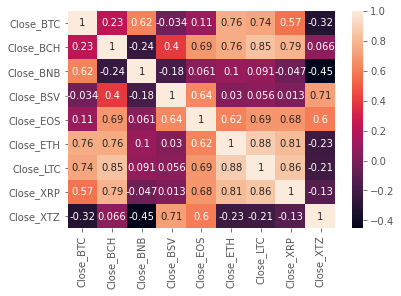

In [885]:
sns.heatmap(corrMatrix, annot=True)
#same-day correlation over all cryptocurrency lifetimes

In [886]:
corrMatrix = df_corr[['Close_BTC', 'Close_BCH_lag_1', 'Close_BNB_lag_1', 'Close_BSV_lag_1', 'Close_EOS_lag_1', 'Close_ETH_lag_1', 'Close_LTC_lag_1', 'Close_XRP_lag_1', 'Close_XTZ_lag_1']].corr()

<AxesSubplot:>

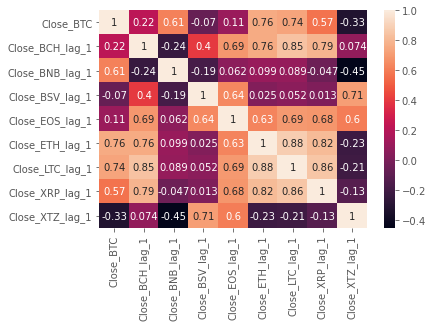

In [887]:
#time-lagged correlation of cryptocurrencies vs. 
#non-time-lagged BTC-USD 
sns.heatmap(corrMatrix, annot=True)

In [888]:
df_corr_time_lag = df_corr[['Close_BTC', 'Close_BCH_lag_1', 'Close_BNB_lag_1', 'Close_BSV_lag_1', 'Close_EOS_lag_1', 'Close_ETH_lag_1', 'Close_LTC_lag_1', 'Close_XRP_lag_1', 'Close_XTZ_lag_1']]

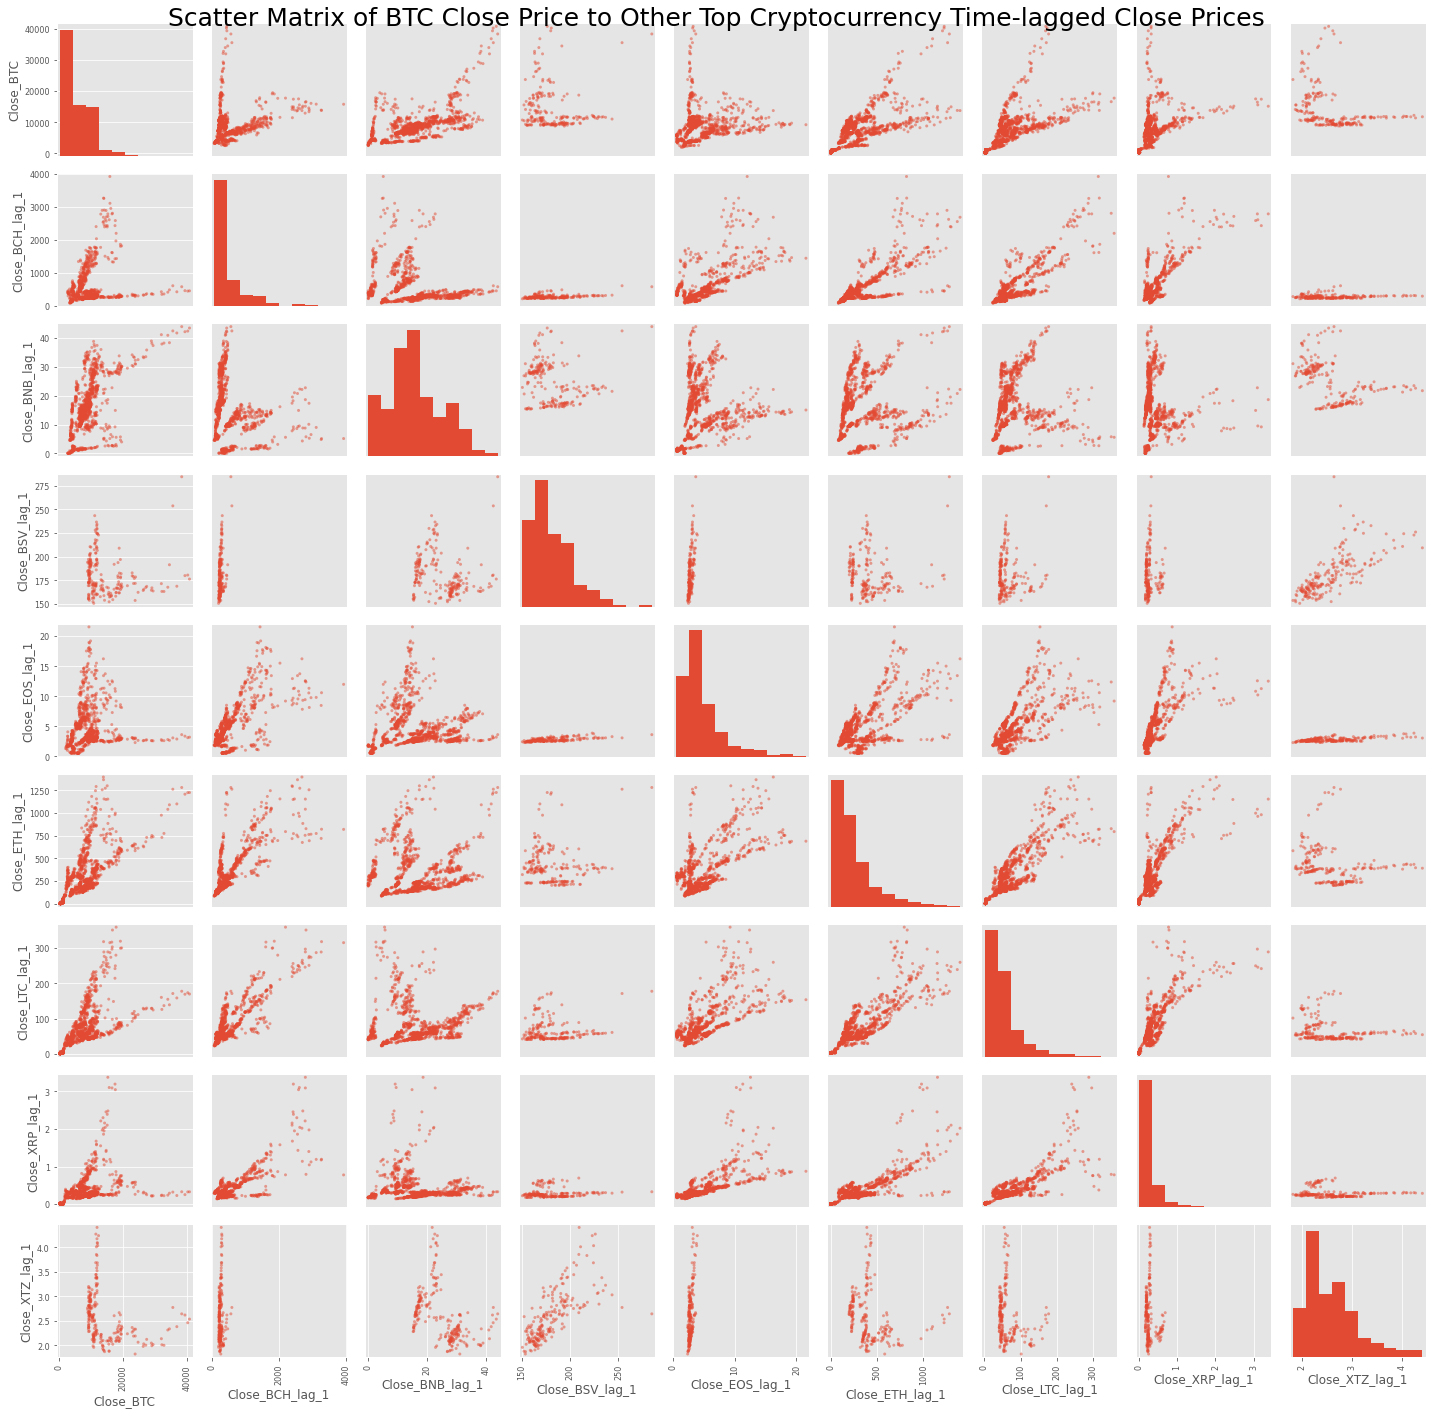

In [889]:
pd.plotting.scatter_matrix(df_corr_time_lag, figsize = (20,20))
plt.suptitle('Scatter Matrix of BTC Close Price to Other Top Cryptocurrency Time-lagged Close Prices', fontsize = 25)
plt.tight_layout()

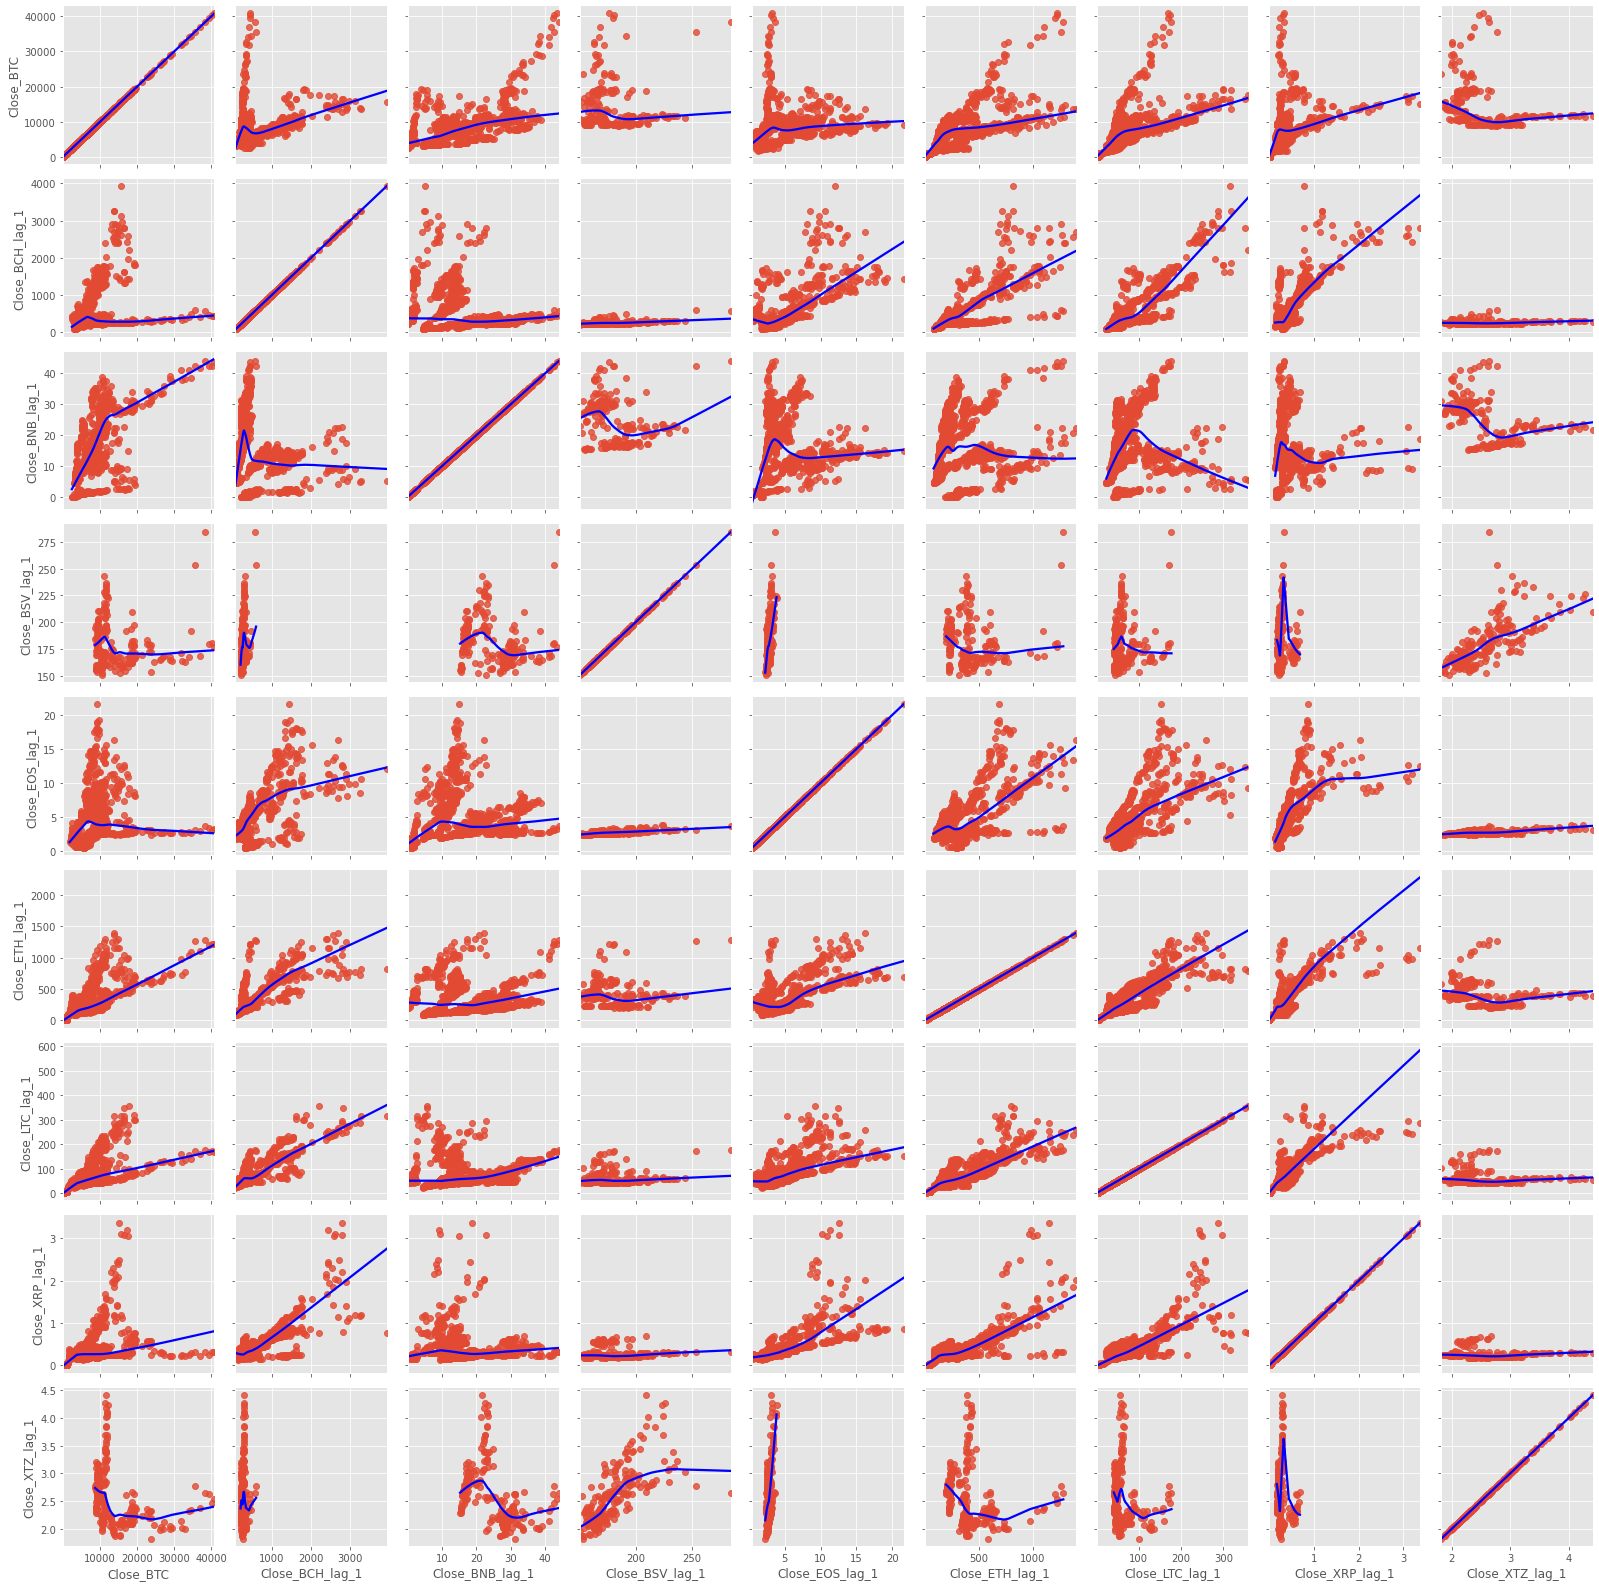

In [890]:
grids = sns.PairGrid(df_corr_time_lag)
grids = grids.map(sns.regplot, lowess=True, scatter = True, line_kws={'color': 'blue'})

In [891]:
#df.corr is NaN tolerant, so no need to account 
#for removing NaN's
df_corr_time_lag.corr()['Close_BTC']

Close_BTC          1.000000
Close_BCH_lag_1    0.220000
Close_BNB_lag_1    0.614383
Close_BSV_lag_1   -0.069905
Close_EOS_lag_1    0.106946
Close_ETH_lag_1    0.756566
Close_LTC_lag_1    0.736227
Close_XRP_lag_1    0.569495
Close_XTZ_lag_1   -0.328802
Name: Close_BTC, dtype: float64

In [892]:
#highest correlation of BTC Close Price among ETH, LTC, XRP,
#and BNB; will test for multicollinearity in subsequent
#time series model via VIF score, if VIF > 5, 
#multicollinearity exists!
#these correlations consider all available data!!!

In [893]:
#However, for linear trend/seasonal time series model, 
#upward linear trend initiates in March, 2020
#However, correlation from February, 2020 to Present 
#will be considered to add to first model

In [894]:
df_corr_baseline = df_corr_time_lag[df_corr_time_lag.index >= '2020-02-01']

In [895]:
corrMatrix_baseline = df_corr_baseline.corr()

<AxesSubplot:>

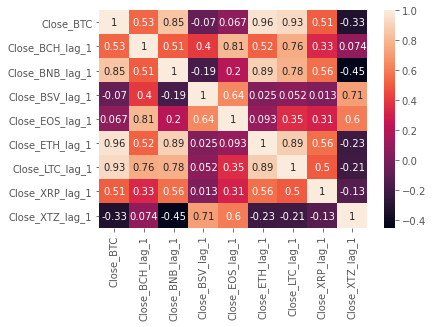

In [896]:
sns.heatmap(corrMatrix_baseline, annot=True)

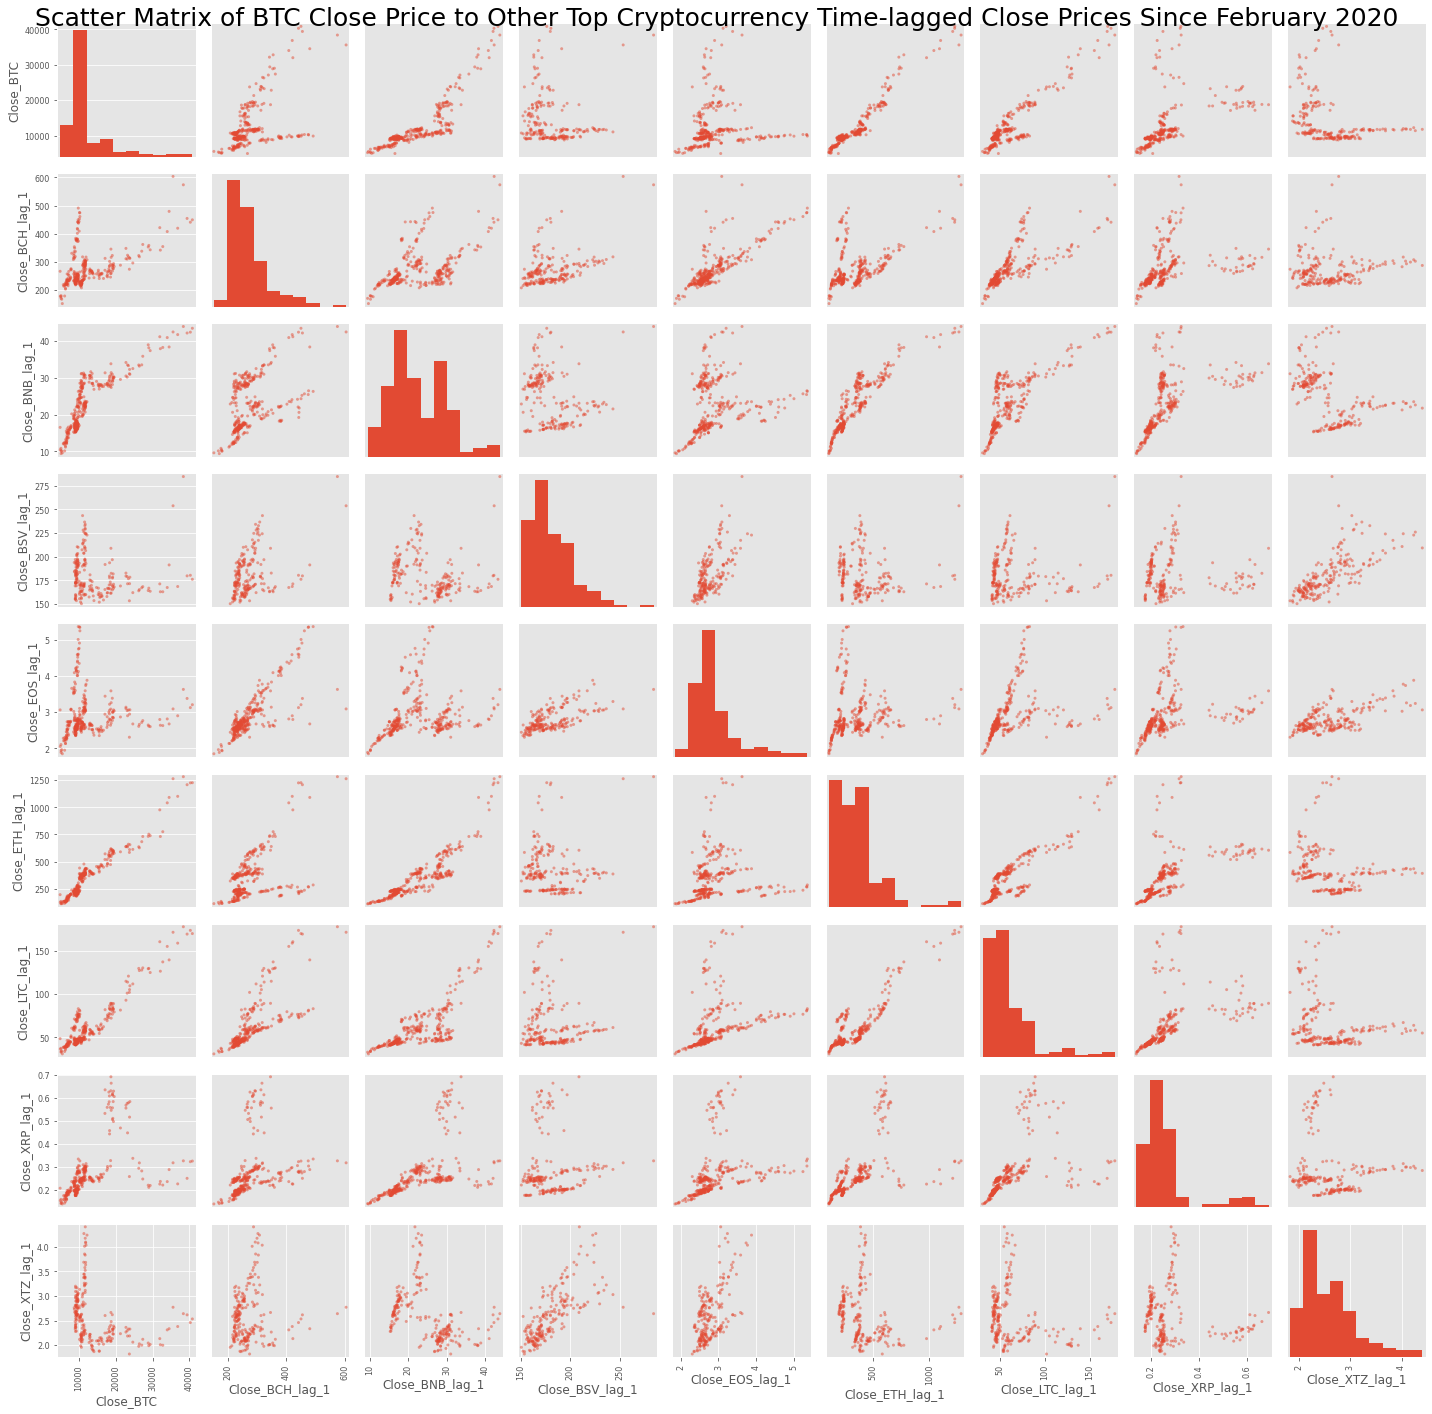

In [897]:
pd.plotting.scatter_matrix(df_corr_baseline, figsize = (20,20))
plt.suptitle('Scatter Matrix of BTC Close Price to Other Top Cryptocurrency Time-lagged Close Prices Since February 2020', fontsize = 25)
plt.tight_layout()

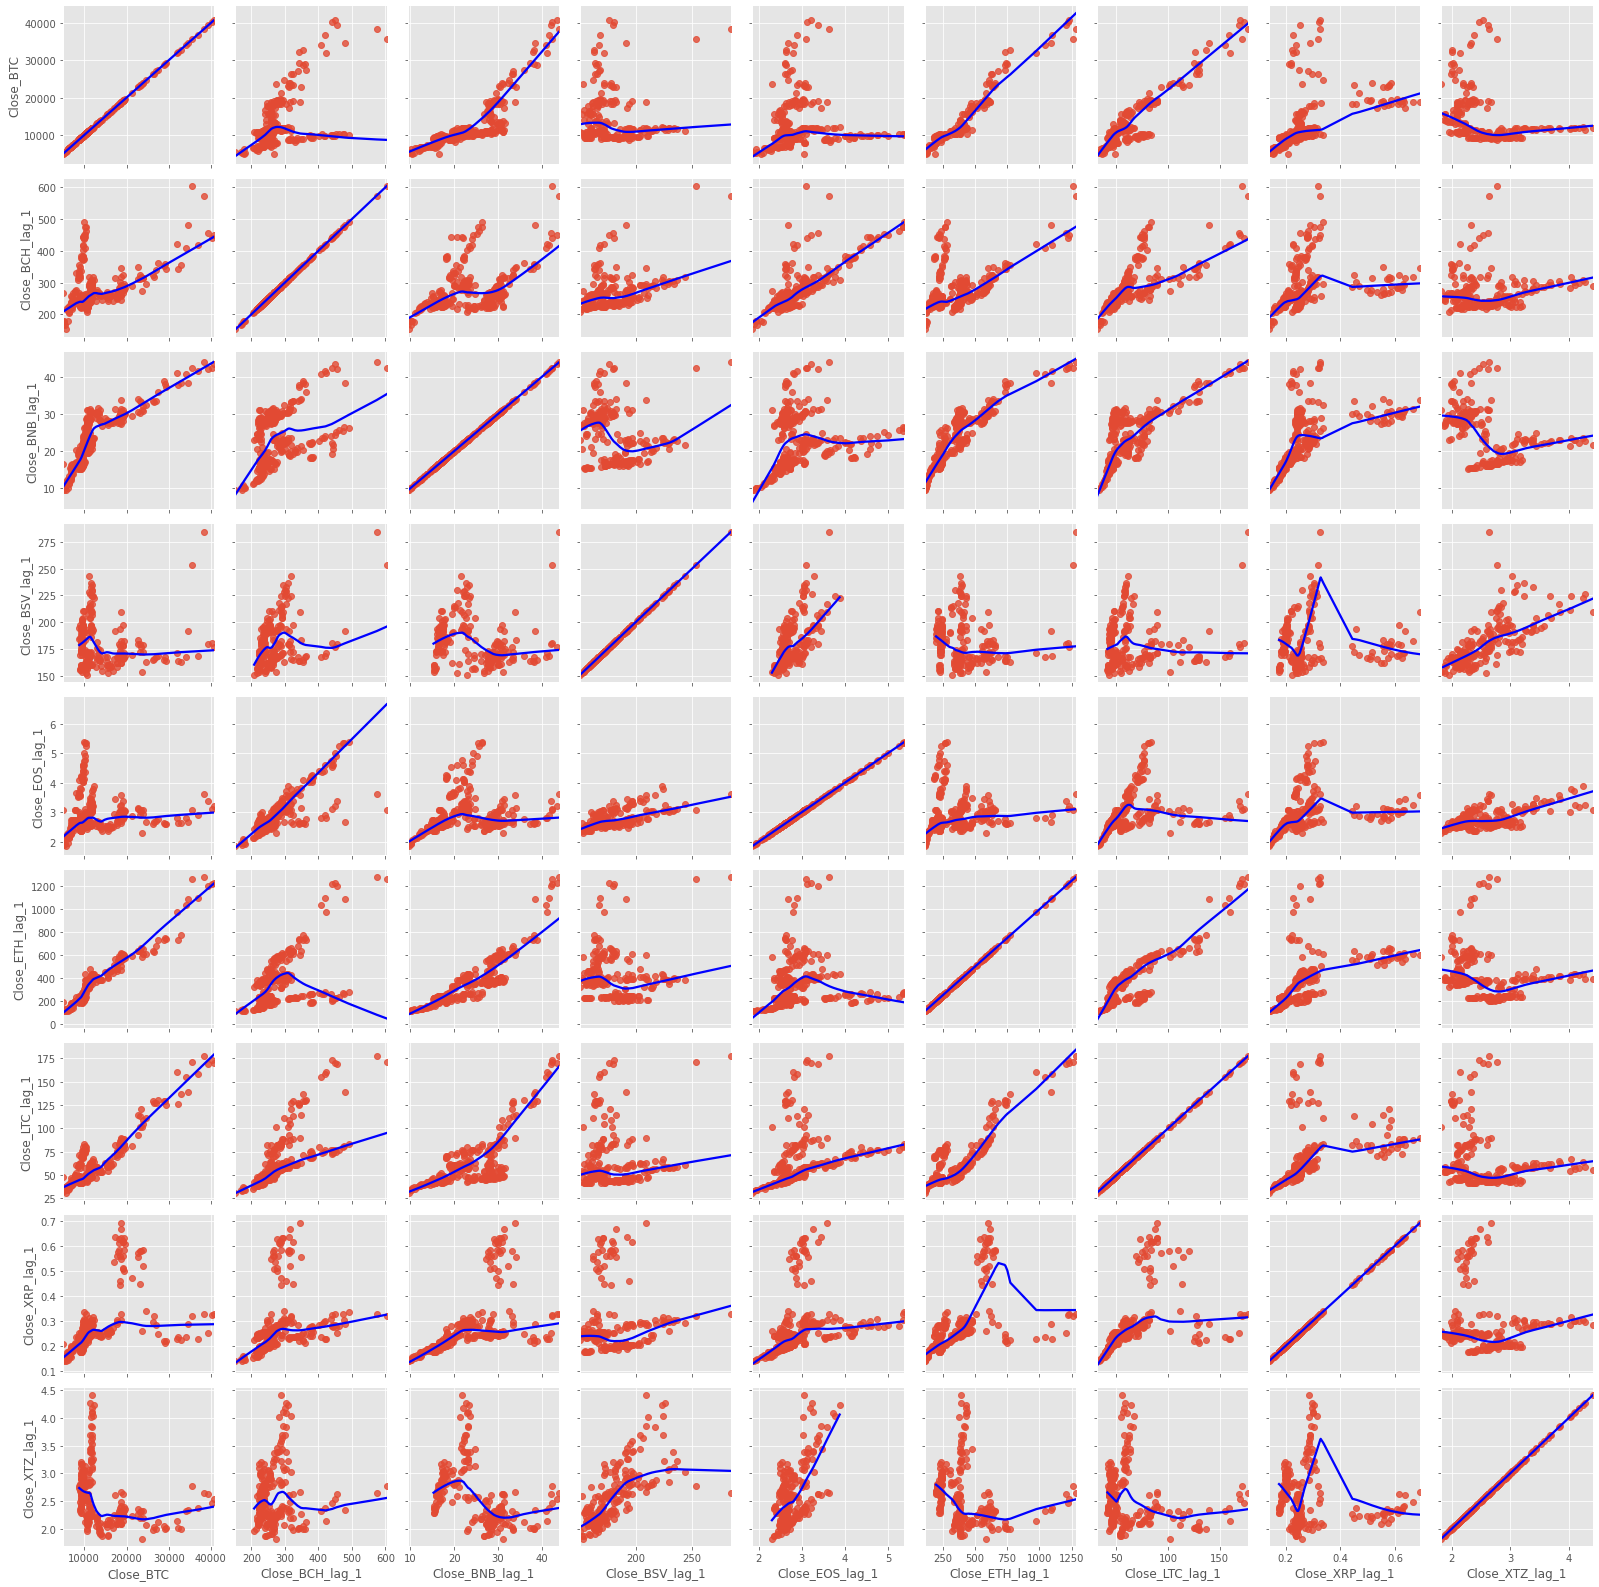

In [898]:
grids = sns.PairGrid(df_corr_baseline)
grids = grids.map(sns.regplot, lowess=True, scatter = True, line_kws={'color': 'blue'})

In [899]:
#highest correlation of BTC Close Price to ETH, LTC, BNB, 
#BCH, and XRP
#will test for multicollinearity of explanatory variables 
#when constructing best-fit model

Text(0, 0.5, 'BTC Closing Price (in USD)')

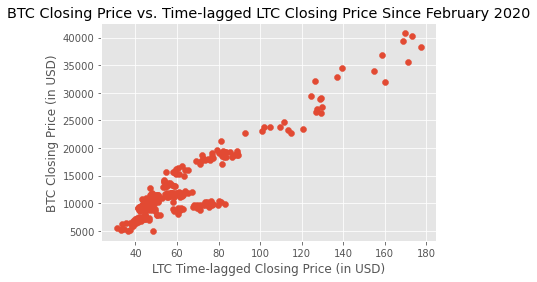

In [900]:
fig, ax = plt.subplots()
ax.scatter(x = df_corr_baseline['Close_LTC_lag_1'], y = df_corr_baseline['Close_BTC'])
ax.set_title('BTC Closing Price vs. Time-lagged LTC Closing Price Since February 2020')
ax.set_xlabel('LTC Time-lagged Closing Price (in USD)')
ax.set_ylabel('BTC Closing Price (in USD)')

Text(0, 0.5, 'BTC Closing Price (in USD)')

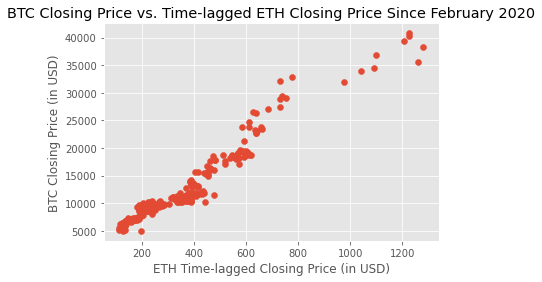

In [901]:
fig, ax = plt.subplots()
ax.scatter(x = df_corr_baseline['Close_ETH_lag_1'], y = df_corr_baseline['Close_BTC'])
ax.set_title('BTC Closing Price vs. Time-lagged ETH Closing Price Since February 2020')
ax.set_xlabel('ETH Time-lagged Closing Price (in USD)')
ax.set_ylabel('BTC Closing Price (in USD)')

Text(0, 0.5, 'BTC Closing Price (in USD)')

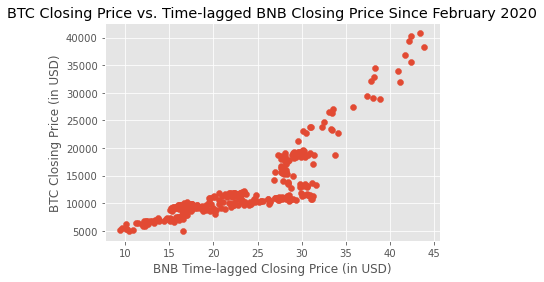

In [902]:
fig, ax = plt.subplots()
ax.scatter(x = df_corr_baseline['Close_BNB_lag_1'], y = df_corr_baseline['Close_BTC'])
ax.set_title('BTC Closing Price vs. Time-lagged BNB Closing Price Since February 2020')
ax.set_xlabel('BNB Time-lagged Closing Price (in USD)')
ax.set_ylabel('BTC Closing Price (in USD)')

Text(0, 0.5, 'BTC Closing Price (in USD)')

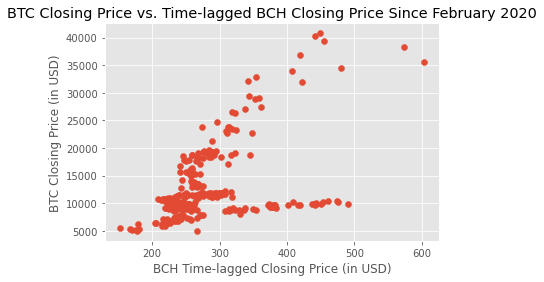

In [903]:
fig, ax = plt.subplots()
ax.scatter(x = df_corr_baseline['Close_BCH_lag_1'], y = df_corr_baseline['Close_BTC'])
ax.set_title('BTC Closing Price vs. Time-lagged BCH Closing Price Since February 2020')
ax.set_xlabel('BCH Time-lagged Closing Price (in USD)')
ax.set_ylabel('BTC Closing Price (in USD)')

Text(0, 0.5, 'BTC Closing Price (in USD)')

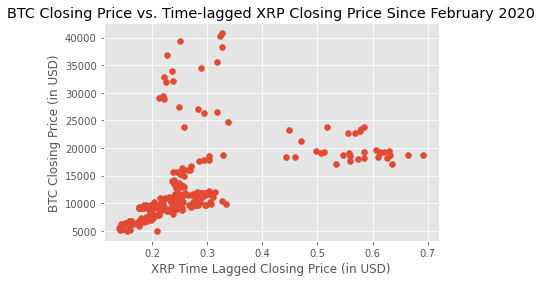

In [904]:
fig, ax = plt.subplots()
ax.scatter(x = df_corr_baseline['Close_XRP_lag_1'], y = df_corr_baseline['Close_BTC'])
ax.set_title('BTC Closing Price vs. Time-lagged XRP Closing Price Since February 2020')
ax.set_xlabel('XRP Time Lagged Closing Price (in USD)')
ax.set_ylabel('BTC Closing Price (in USD)')

In [905]:
df_btc_baseline = df_btc[df_btc.index >= '2020-02-01']

In [906]:
df_btc_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 347 entries, 2020-02-01 to 2021-01-12
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  347 non-null    float64
 1   High                  347 non-null    float64
 2   Low                   347 non-null    float64
 3   Close                 347 non-null    float64
 4   Adj Close             347 non-null    float64
 5   Volume                347 non-null    int64  
 6   Volume_Price          347 non-null    float64
 7   10_Day_VWAP           347 non-null    float64
 8   Daily_Return          347 non-null    float64
 9   Biweekly_RS           347 non-null    float64
 10  Biweekly_RSI          347 non-null    float64
 11  12_day_EMA            347 non-null    float64
 12  26_day_EMA            347 non-null    float64
 13  MACD                  347 non-null    float64
 14  Signal                347 non-null    float64
 15  Trend_Analys

In [911]:
#Since Feb 1, 2020, 347 days have elapsed, so all dates 
#are accounted for
#Relative Time will initiate at Feb 1, 2020 = 0 and 
#end on Jan 12, 2020 = 346, in terms of days elapsed

In [908]:
df_btc_baseline['Relative_Time'] = float('NaN')

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [909]:
for i in range(len(df_btc_baseline)):
    df_btc_baseline['Relative_Time'][i] = i

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jonathon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [919]:
#first model will just consider relative time to visualize trend
model1 = ols('np.log(Close) ~ Relative_Time', data = df_btc_baseline).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Close)   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     790.6
Date:                Tue, 12 Jan 2021   Prob (F-statistic):           2.88e-91
Time:                        14:09:45   Log-Likelihood:                 35.503
No. Observations:                 347   AIC:                            -67.01
Df Residuals:                     345   BIC:                            -59.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.7478      0.023    372.727      0.000       8.702       8.794
Relative_Time     0.0033      0.000     28.117      0.000       0.003       0.004
==============================================================================
Omnibus:                       52.444   Durbin-Watson:                   0.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.015
Skew:                           1.047   Prob(JB):                     2.30e-16
Kurtosis:                       3.769   Cond. No.                         399.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [920]:
df_btc_model1 = stat()
df_btc_model1.anova_stat(df = df_btc_baseline, res_var='Close', anova_model='np.log(Close) ~ Relative_Time')
df_btc_model1.anova_summary

df     sum_sq    mean_sq           F        PR(>F)
Relative_Time    1.0  37.941458  37.941458  790.582181  2.880036e-91
Residual       345.0  16.557169   0.047992         NaN           NaN

In [932]:
model1_fitted_y_values = model1.fittedvalues
model1_norm_resids = df_btc_model1.anova_std_residuals
model1_norm_resids_abs_sqrt = np.sqrt(np.abs(model1_norm_resids))
model1_lev = model1.get_influence().hat_matrix_diag

/home/jonathon/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Residuals')

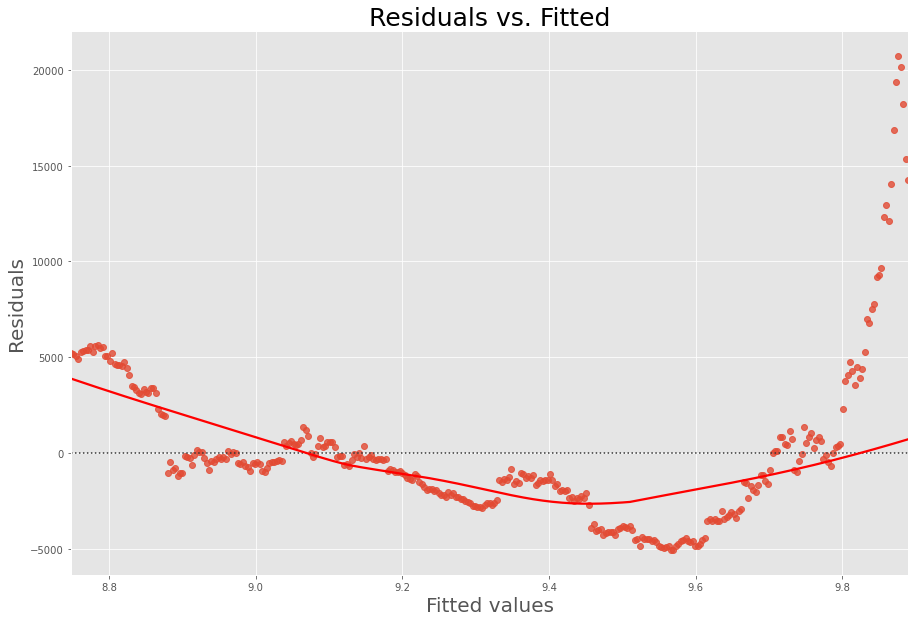

In [933]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.residplot(model1_fitted_y_values, df_btc_baseline['Close'], lowess = True, line_kws = {'color': 'red'})
ax.set_title('Residuals vs. Fitted', fontsize = 25)
ax.set_xlabel('Fitted values', fontsize = 20)
ax.set_ylabel('Residuals', fontsize = 20)
#AUTOREGRESSION EVIDENT

Text(0, 0.5, 'Standardized residuals')

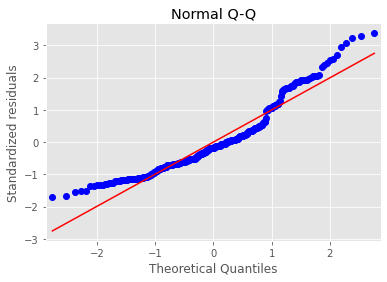

In [934]:
QQ = sgg.ProbPlot(model1_norm_resids)
qq_plot = QQ.qqplot(line = 's')
qq_plot.axes[0].set_title('Normal Q-Q')
qq_plot.axes[0].set_ylabel('Standardized residuals')

/home/jonathon/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'sqrt(abs(Standardized residuals))')

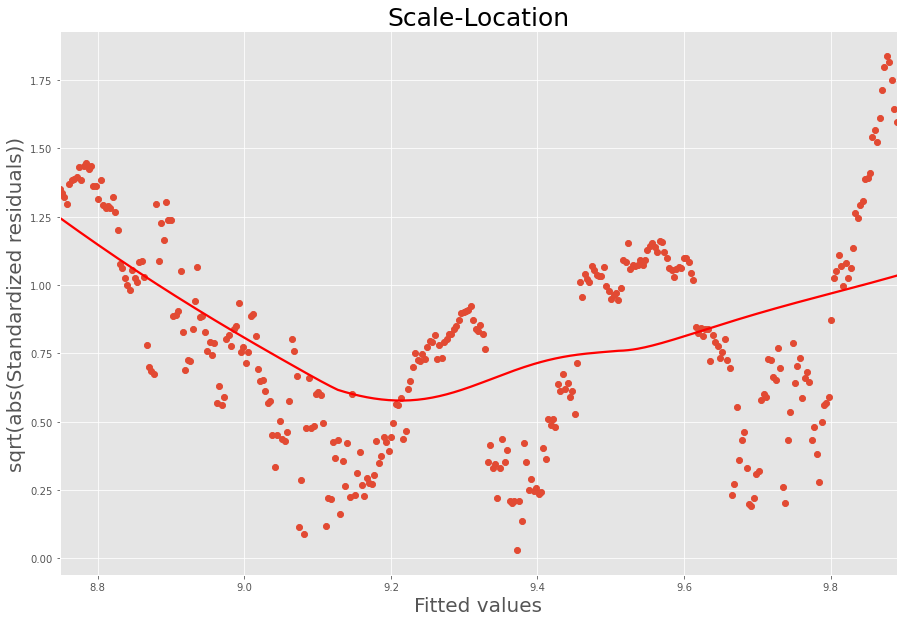

In [937]:
fig, ax = plt.subplots(figsize = (15, 10))
plt_scatter = plt.scatter(model1_fitted_y_values, model1_norm_resids_abs_sqrt)
plt_scale_location = sns.regplot(model1_fitted_y_values, model1_norm_resids_abs_sqrt, lowess = True, 
                                 line_kws = {'color': 'red'})
ax.set_title('Scale-Location', fontsize = 25)
ax.set_xlabel('Fitted values', fontsize = 20)
ax.set_ylabel('sqrt(abs(Standardized residuals))', fontsize = 20)
#Autoregression EVIDENT

/home/jonathon/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Standardized Residuals')

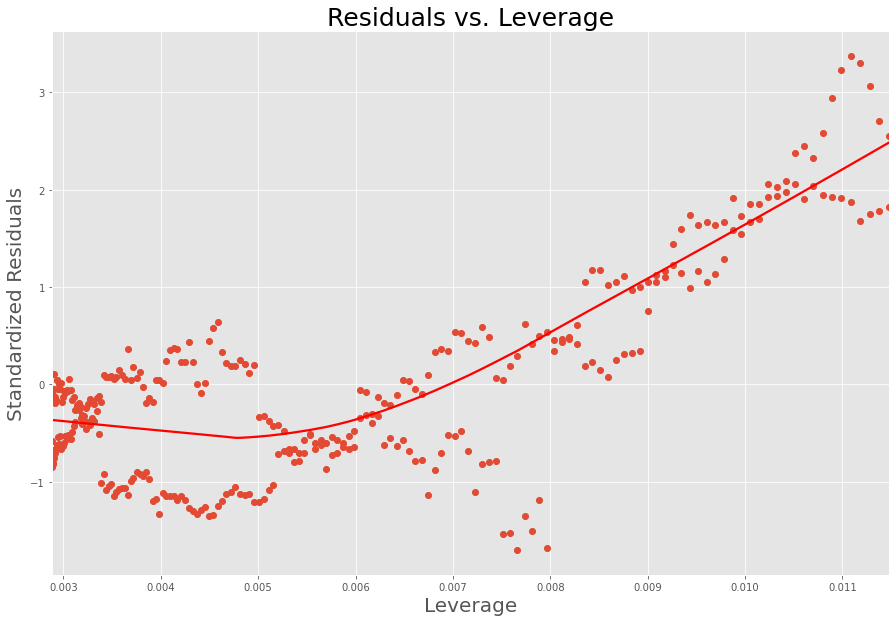

In [938]:
fig, ax = plt.subplots(figsize = (15, 10))
plt.scatter(model1_lev, model1_norm_resids)
sns.regplot(model1_lev, model1_norm_resids, lowess=True, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Leverage', fontsize = 25)
ax.set_xlabel('Leverage', fontsize = 20)
ax.set_ylabel('Standardized Residuals', fontsize = 20)

In [939]:
#The first model, model1, could be used as a comparison in 
#terms of improving RMSE of subsequent models
#Based on assumptions of linear regression, 
#i.e. a general linear trend between the 
#response/explanatory variables,
#no multicollinearity amongst its' explanatory variables, 
#normality of its' residuals, and 
#randomness of its' residuals with constant variation; 
#there is no randomness to its' errors, 
#i.e. there is an autoregressive/cyclical nature to them,
#therefore this model is not appropriate/cannot be used

In [940]:
#incorporate monthly seasonality into model 
#via monthly dummy variables
df_btc_baseline['Month'] = pd.to_datetime(df_btc_baseline.index).month

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [941]:
df_dummies_months = pd.get_dummies(df_btc_baseline['Month'], drop_first = False)
df_dummies_months.columns = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']

In [942]:
#df_btc_baseline.drop('Month', axis = 1, inplace = True)

In [943]:
df_btc_baseline_dummies = pd.concat([df_btc_baseline, df_dummies_months], axis = 1)

In [944]:
#second model: multiple linear regression with monthly dummies
model2 = ols('np.log(Close) ~ Relative_Time + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + Jan', data = df_btc_baseline_dummies).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Close)   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     514.0
Date:                Tue, 12 Jan 2021   Prob (F-statistic):          4.40e-207
Time:                        14:14:51   Log-Likelihood:                 343.88
No. Observations:                 347   AIC:                            -661.8
Df Residuals:                     334   BIC:                            -611.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.1566      0.095     86.049      0.000       7.970       8.343
Relative_Time     0.0030      0.001      5.265      0.000       0.002       0.004
Feb               1.2985      0.102     12.786      0.000       1.099       1.498
Mar               0.9730      0.088     11.025      0.000       0.799       1.147
Apr               0.5279      0.071      7.384      0.000       0.387       0.669
May               0.5036      0.055      9.187      0.000       0.396       0.611
Jun               0.6627      0.039     17.208      0.000       0.587       0.739
Jul               0.5962      0.024     24.852      0.000       0.549       0.643
Aug               0.5136      0.016     32.414      0.000       0.482       0.545
Sep               0.6180      0.023     26.527      0.000       0.572       0.664
Oct               0.4374      0.038     11.524      0.000       0.363       0.512
Nov               0.4522      0.054      8.365      0.000       0.346       0.559
Dec               0.6963      0.071      9.829      0.000       0.557       0.836
Jan               0.8771      0.088      9.996      0.000       0.704       1.050
==============================================================================
Omnibus:                       42.709   Durbin-Watson:                   0.413
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.008
Skew:                           0.544   Prob(JB):                     1.18e-27
Kurtosis:                       5.719   Cond. No.                     1.15e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.04e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [945]:
df_btc_model2 = stat()
df_btc_model2.anova_stat(df = df_btc_baseline_dummies, res_var='Close', 
                                  anova_model='np.log(Close) ~ Relative_Time + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + Jan')
df_btc_model2.anova_summary

df    sum_sq   mean_sq            F         PR(>F)
Relative_Time    1.0  0.232358  0.232358    27.722488   2.512357e-07
Feb              1.0  1.370147  1.370147   163.471104   9.643407e-31
Mar              1.0  1.018825  1.018825   121.555193   2.584973e-24
Apr              1.0  0.457036  0.457036    54.528640   1.231874e-12
May              1.0  0.707442  0.707442    84.404372   4.380024e-18
Jun              1.0  2.481790  2.481790   296.100353   5.841405e-48
Jul              1.0  5.176848  5.176848   617.645569   6.211695e-78
Aug              1.0  8.806337  8.806337  1050.677005  3.628568e-105
Sep              1.0  5.897870  5.897870   703.670126   3.215363e-84
Oct              1.0  1.113031  1.113031   132.794863   4.276890e-26
Nov              1.0  0.586481  0.586481    69.972606   1.657211e-15
Dec              1.0  0.809787  0.809787    96.615066   3.409295e-20
Jan              1.0  0.837557  0.837557    99.928236   9.359596e-21
Residual       334.0  2.799449  0.008382          NaN            NaN

In [946]:
model2_fitted_y_values = model2.fittedvalues
model2_norm_resids = df_btc_model2.anova_std_residuals
model2_norm_resids_abs_sqrt = np.sqrt(np.abs(model2_norm_resids))
model2_lev = model2.get_influence().hat_matrix_diag

/home/jonathon/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Residuals')

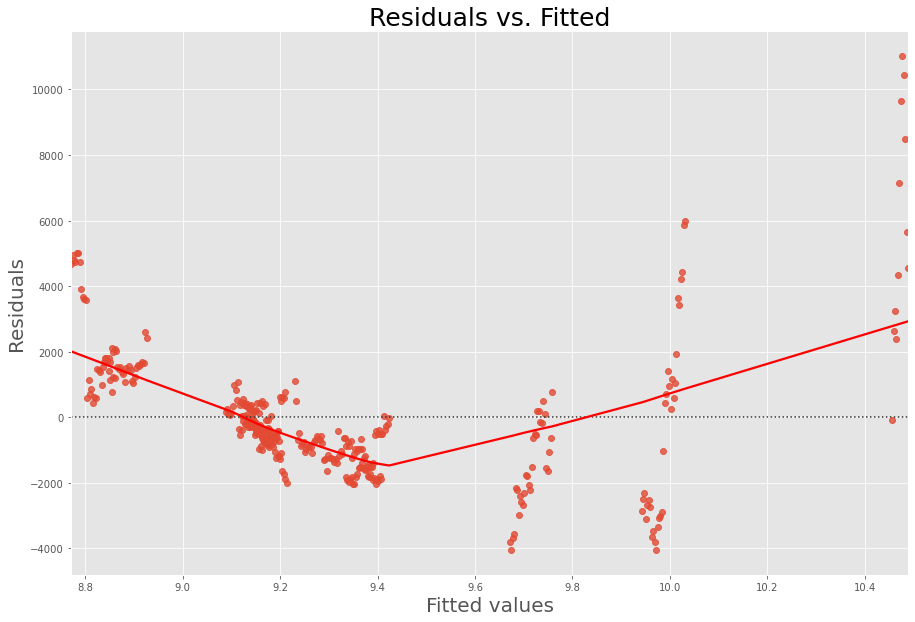

In [947]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.residplot(model2_fitted_y_values, df_btc_baseline_dummies['Close'], lowess = True, line_kws = {'color': 'red'})
ax.set_title('Residuals vs. Fitted', fontsize = 25)
ax.set_xlabel('Fitted values', fontsize = 20)
ax.set_ylabel('Residuals', fontsize = 20)

Text(0, 0.5, 'Standardized residuals')

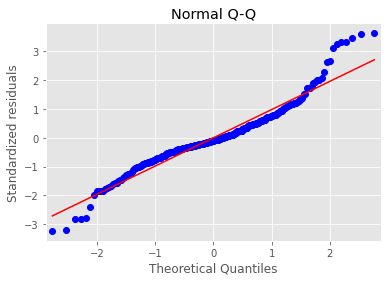

In [948]:
QQ = sgg.ProbPlot(model2_norm_resids)
qq_plot = QQ.qqplot(line = 's')
qq_plot.axes[0].set_title('Normal Q-Q')
qq_plot.axes[0].set_ylabel('Standardized residuals')

/home/jonathon/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'sqrt(abs(Standardized residuals))')

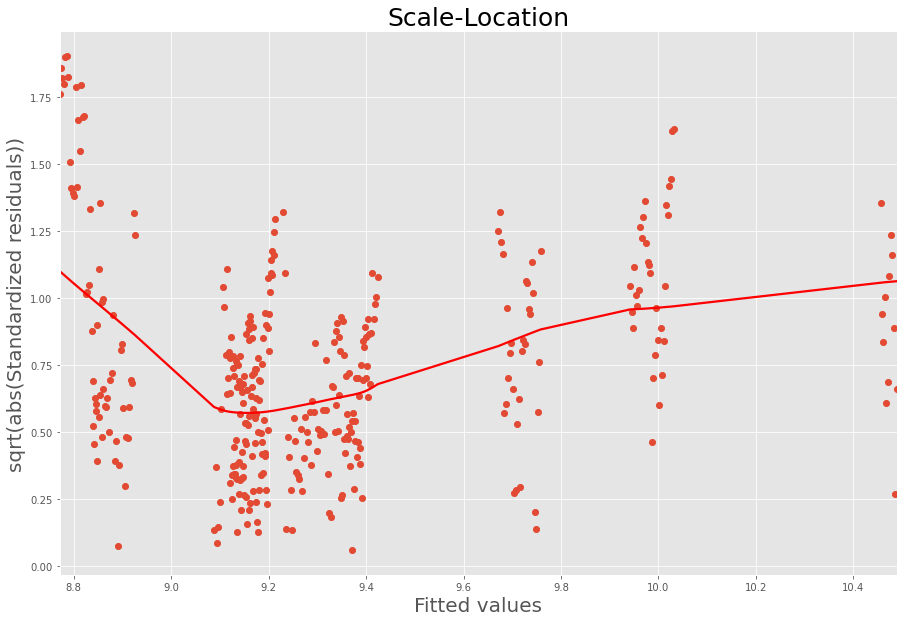

In [949]:
fig, ax = plt.subplots(figsize = (15, 10))
plt_scatter = plt.scatter(model2_fitted_y_values, model2_norm_resids_abs_sqrt)
plt_scale_location = sns.regplot(model2_fitted_y_values, model2_norm_resids_abs_sqrt, lowess = True, 
                                 line_kws = {'color': 'red'})
ax.set_title('Scale-Location', fontsize = 25)
ax.set_xlabel('Fitted values', fontsize = 20)
ax.set_ylabel('sqrt(abs(Standardized residuals))', fontsize = 20)
#constant variation and randomness of errors/residuals

/home/jonathon/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Standardized Residuals')

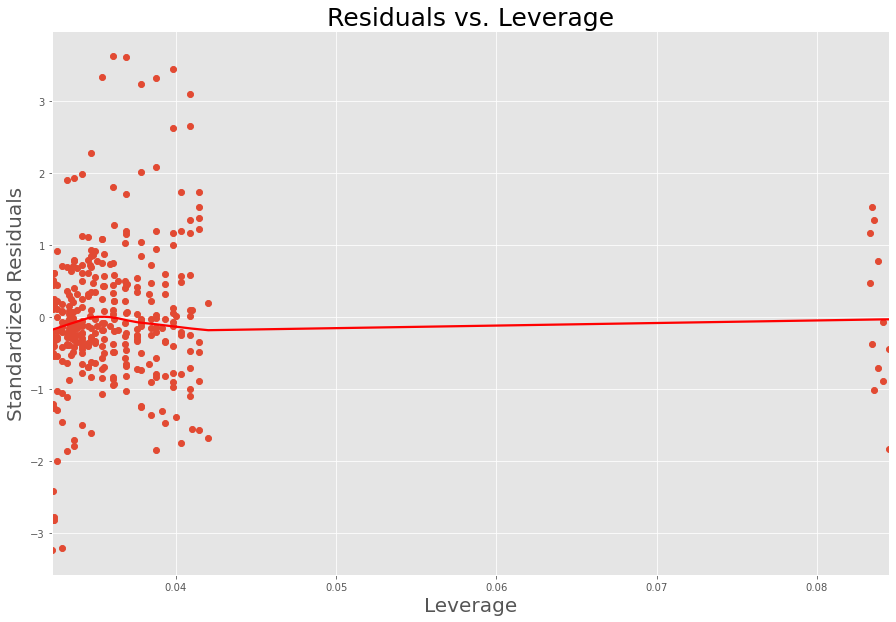

In [950]:
fig, ax = plt.subplots(figsize = (15, 10))
plt.scatter(model2_lev, model2_norm_resids)
sns.regplot(model2_lev, model2_norm_resids, lowess=True, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Leverage', fontsize = 25)
ax.set_xlabel('Leverage', fontsize = 20)
ax.set_ylabel('Standardized Residuals', fontsize = 20)

In [951]:
y_pred_2 = model2.predict(df_btc_baseline_dummies[['Relative_Time', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']])

In [952]:
y_pred_1 = model1.predict(df_btc_baseline['Relative_Time'])

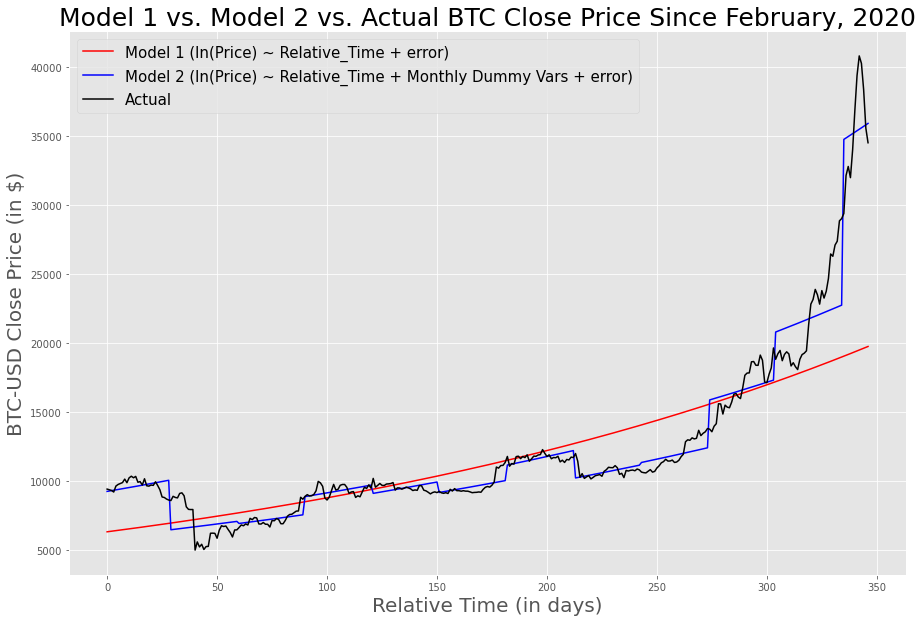

In [953]:
fig, ax = plt.subplots(figsize = (15, 10))
t = df_btc_baseline_dummies['Relative_Time']
actual = df_btc_baseline['Close']
ax.plot(t, e**y_pred_1, color = 'red', label = 'Model 1 (ln(Price) ~ Relative_Time + error)')
ax.plot(t, e**y_pred_2, color = 'blue', label = 'Model 2 (ln(Price) ~ Relative_Time + Monthly Dummy Vars + error)')
ax.plot(t, actual, color = 'black', label = 'Actual')
ax.set_title('Model 1 vs. Model 2 vs. Actual BTC Close Price Since February, 2020', fontsize = 25)
ax.set_xlabel('Relative Time (in days)', fontsize = 20)
ax.set_ylabel('BTC-USD Close Price (in $)', fontsize = 20)
plt.legend(fontsize = 15)

In [954]:
#Strengthen model with correlated time-lagged cryptocurrencies 
#of ETH, LTC, BNB, BCH, and XRP

In [955]:
df_btc_CCC_dummies = pd.concat([df_btc_baseline_dummies, df_corr_baseline[['Close_LTC_lag_1', 'Close_ETH_lag_1', 'Close_BNB_lag_1', 'Close_BCH_lag_1', 'Close_XRP_lag_1']]], axis = 1)

In [956]:
df_btc_CCC_dummies.info() #all non-null values!

<class 'pandas.core.frame.DataFrame'>
Index: 347 entries, 2020-02-01 to 2021-01-12
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Open                  347 non-null    float64
 1   High                  347 non-null    float64
 2   Low                   347 non-null    float64
 3   Close                 347 non-null    float64
 4   Adj Close             347 non-null    float64
 5   Volume                347 non-null    int64  
 6   Volume_Price          347 non-null    float64
 7   10_Day_VWAP           347 non-null    float64
 8   Daily_Return          347 non-null    float64
 9   Biweekly_RS           347 non-null    float64
 10  Biweekly_RSI          347 non-null    float64
 11  12_day_EMA            347 non-null    float64
 12  26_day_EMA            347 non-null    float64
 13  MACD                  347 non-null    float64
 14  Signal                347 non-null    float64
 15  Trend_Analys

In [957]:
#third model with these additional variables
model3 = ols('Close ~ Relative_Time + Feb + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + Jan + Close_LTC_lag_1 + Close_ETH_lag_1 + Close_BNB_lag_1 + Close_BCH_lag_1 + Close_XRP_lag_1', 
             data = df_btc_CCC_dummies).fit()
model3.summary()
#Close_BNB_lag_1's t-stat p-value is largest and greater than an alpha of 0.05, therefore it is statistically insignificant
#in describing the variation in BTC's Close Price for this time interval, will drop in subsequent model
#Mar is default month and is removed from set of monthly dummy variables

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2004.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):          2.21e-320
Time:                        14:16:04   Log-Likelihood:                -2716.5
No. Observations:                 347   AIC:                             5469.
Df Residuals:                     329   BIC:                             5538.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1364.2410    544.943      2.503      0.013     292.230    2436.252
Relative_Time      21.5783      4.543      4.749      0.000      12.640      30.516
Feb              3605.8022   1314.637      2.743      0.006    1019.646    6191.958
Apr              -410.0770    274.928     -1.492      0.137    -950.915     130.761
May              -517.2757    344.664     -1.501      0.134   -1195.299     160.747
Jun               434.4977    436.301      0.996      0.320    -423.794    1292.789
Jul              -189.0988    550.256     -0.344      0.731   -1271.563     893.365
Aug              -914.8485    663.825     -1.378      0.169   -2220.725     391.028
Sep             -1656.2819    771.525     -2.147      0.033   -3174.026    -138.537
Oct             -2247.1952    902.337     -2.490      0.013   -4022.274    -472.117
Nov             -1867.2745   1029.222     -1.814      0.071   -3891.961     157.412
Dec              -139.4907   1118.217     -0.125      0.901   -2339.247    2060.266
Jan               589.7272   1215.354      0.485      0.628   -1801.118    2980.573
Close_LTC_lag_1   123.1112      7.497     16.422      0.000     108.364     137.859
Close_ETH_lag_1     6.2316      1.232      5.059      0.000       3.809       8.655
Close_BNB_lag_1     6.6373     26.566      0.250      0.803     -45.623      58.897
Close_BCH_lag_1    -4.0218      2.121     -1.896      0.059      -8.194       0.151
Close_XRP_lag_1 -3691.2810    605.016     -6.101      0.000   -4881.469   -2501.093
==============================================================================
Omnibus:                       73.960   Durbin-Watson:                   1.412
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              592.304
Skew:                          -0.615   Prob(JB):                    2.41e-129
Kurtosis:                       9.281   Cond. No.                     4.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [959]:
model4 = ols('Close ~ Relative_Time + Feb + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + Jan + Close_LTC_lag_1 + Close_ETH_lag_1 + Close_BCH_lag_1 + Close_XRP_lag_1', 
             data = df_btc_CCC_dummies).fit()
model4.summary()
#Dec's t-stat p-value is largest and greater than an alpha of 0.05, therefore it
#is statistically insignificant in describing the variation in BTC's Close Price for this time interval, 
#will drop in subsequent model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2135.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):          4.84e-322
Time:                        14:17:47   Log-Likelihood:                -2716.5
No. Observations:                 347   AIC:                             5467.
Df Residuals:                     330   BIC:                             5532.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1373.4809    542.913      2.530      0.012     305.473    2441.488
Relative_Time      21.8651      4.390      4.981      0.000      13.230      30.500
Feb              3605.8756   1312.769      2.747      0.006    1023.425    6188.326
Apr              -416.0415    273.500     -1.521      0.129    -954.064     121.981
May              -524.4287    342.985     -1.529      0.127   -1199.141     150.283
Jun               427.4339    434.765      0.983      0.326    -427.827    1282.694
Jul              -203.8489    546.302     -0.373      0.709   -1278.523     870.825
Aug              -930.7279    659.836     -1.411      0.159   -2228.743     367.287
Sep             -1666.3557    769.375     -2.166      0.031   -3179.854    -152.857
Oct             -2227.0255    897.441     -2.482      0.014   -3992.452    -461.599
Nov             -1832.6329   1018.390     -1.800      0.073   -3835.989     170.723
Dec              -130.4266   1116.039     -0.117      0.907   -2325.875    2065.022
Jan               587.2997   1213.588      0.484      0.629   -1800.044    2974.643
Close_LTC_lag_1   123.5980      7.229     17.098      0.000     109.378     137.818
Close_ETH_lag_1     6.2108      1.227      5.061      0.000       3.797       8.625
Close_BCH_lag_1    -3.7683      1.860     -2.026      0.044      -7.428      -0.109
Close_XRP_lag_1 -3696.0590    603.854     -6.121      0.000   -4883.948   -2508.170
==============================================================================
Omnibus:                       74.155   Durbin-Watson:                   1.412
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              598.641
Skew:                          -0.615   Prob(JB):                    1.02e-130
Kurtosis:                       9.316   Cond. No.                     4.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [961]:
model5 = ols('Close ~ Relative_Time + Feb + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Jan + Close_LTC_lag_1 + Close_BCH_lag_1 + Close_XRP_lag_1 + Close_ETH_lag_1', 
             data = df_btc_CCC_dummies).fit()
model5.summary()
#Jul's t-stat p-value is largest and greater than an alpha of 0.05, 
#therefore it is statistically insignificant in describing the variation in BTC's Close Price for this time interval, 
#will drop in subsequent model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2285.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):          9.88e-324
Time:                        14:18:49   Log-Likelihood:                -2716.5
No. Observations:                 347   AIC:                             5465.
Df Residuals:                     331   BIC:                             5527.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1376.1522    541.623      2.541      0.012     310.695    2441.610
Relative_Time      21.3937      1.729     12.375      0.000      17.993      24.794
Feb              3748.9037    474.170      7.906      0.000    2816.136    4681.671
Apr              -399.5892    234.135     -1.707      0.089    -860.170      60.991
May              -493.3445    216.222     -2.282      0.023    -918.687     -68.002
Jun               472.7663    196.055      2.411      0.016      87.095     858.438
Jul              -144.0458    190.982     -0.754      0.451    -519.737     231.646
Aug              -856.6303    182.418     -4.696      0.000   -1215.475    -497.785
Sep             -1578.4275    160.547     -9.832      0.000   -1894.248   -1262.607
Oct             -2124.4093    185.180    -11.472      0.000   -2488.687   -1760.132
Nov             -1715.5324    181.648     -9.444      0.000   -2072.863   -1358.202
Jan               726.5837    228.428      3.181      0.002     277.229    1175.938
Close_LTC_lag_1   123.7868      7.035     17.595      0.000     109.947     137.626
Close_BCH_lag_1    -3.7933      1.845     -2.056      0.041      -7.423      -0.164
Close_XRP_lag_1 -3697.7644    602.778     -6.135      0.000   -4883.523   -2512.006
Close_ETH_lag_1     6.2079      1.225      5.067      0.000       3.798       8.618
==============================================================================
Omnibus:                       74.325   Durbin-Watson:                   1.413
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              601.697
Skew:                          -0.616   Prob(JB):                    2.20e-131
Kurtosis:                       9.332   Cond. No.                     1.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [966]:
model6 = ols('Close ~ Relative_Time + Feb + Jun + Aug + Sep + Oct + Nov + Jan + Close_LTC_lag_1 + Close_XRP_lag_1 + Close_ETH_lag_1', 
             data = df_btc_CCC_dummies).fit()
model6.summary()
#Apr, May, and Close_BCH's t-stat p-values were also greater than an alpha of 0.05, 
#therefore they were statistically insignificant in describing the variation in BTC's Close Price for this time interval
#and were not included as well

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     3085.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):               0.00
Time:                        14:21:35   Log-Likelihood:                -2720.3
No. Observations:                 347   AIC:                             5465.
Df Residuals:                     335   BIC:                             5511.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         262.2104    195.150      1.344      0.180    -121.664     646.085
Relative_Time      24.3168      1.123     21.654      0.000      22.108      26.526
Feb              3789.1227    441.227      8.588      0.000    2921.199    4657.047
Jun               749.7038    126.315      5.935      0.000     501.232     998.175
Aug              -700.5371    132.336     -5.294      0.000    -960.851    -440.224
Sep             -1521.0626    139.880    -10.874      0.000   -1796.216   -1245.910
Oct             -1994.1628    148.086    -13.466      0.000   -2285.459   -1702.866
Nov             -1725.0698    149.089    -11.571      0.000   -2018.338   -1431.802
Jan               766.2803    199.651      3.838      0.000     373.552    1159.008
Close_LTC_lag_1   119.8394      5.198     23.055      0.000     109.614     130.064
Close_XRP_lag_1 -3817.3150    542.636     -7.035      0.000   -4884.719   -2749.911
Close_ETH_lag_1     5.3066      1.139      4.658      0.000       3.066       7.548
==============================================================================
Omnibus:                       75.573   Durbin-Watson:                   1.456
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              681.937
Skew:                          -0.593   Prob(JB):                    8.31e-149
Kurtosis:                       9.765   Cond. No.                     8.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [967]:
#calculate VIF scores of additional variables to other variables
model1_XRP = ols('Close_XRP_lag_1 ~ Relative_Time + Feb + Jun + Aug + Sep + Oct + Nov + Jan + Close_LTC_lag_1 + Close_ETH_lag_1', 
             data = df_btc_CCC_dummies).fit()
model1_XRP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Close_XRP_lag_1   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     67.18
Date:                Tue, 12 Jan 2021   Prob (F-statistic):           5.10e-74
Time:                        14:22:42   Log-Likelihood:                 473.36
No. Observations:                 347   AIC:                            -924.7
Df Residuals:                     336   BIC:                            -882.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1509      0.018      8.471      0.000       0.116       0.186
Relative_Time      -0.0004      0.000     -3.485      0.001      -0.001      -0.000
Feb                -0.3963      0.039    -10.231      0.000      -0.472      -0.320
Jun                -0.0100      0.013     -0.786      0.432      -0.035       0.015
Aug                -0.0316      0.013     -2.395      0.017      -0.058      -0.006
Sep                -0.0278      0.014     -1.991      0.047      -0.055      -0.000
Oct                -0.0515      0.015     -3.522      0.000      -0.080      -0.023
Nov                -0.0400      0.015     -2.701      0.007      -0.069      -0.011
Jan                 0.0945      0.019      4.871      0.000       0.056       0.133
Close_LTC_lag_1    -0.0015      0.001     -2.885      0.004      -0.003      -0.000
Close_ETH_lag_1     0.0008      0.000      7.890      0.000       0.001       0.001
==============================================================================
Omnibus:                       68.064   Durbin-Watson:                   0.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1136.373
Skew:                           0.033   Prob(JB):                    1.74e-247
Kurtosis:                      11.865   Cond. No.                     5.51e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [968]:
VIF_XRP = 1/(1-0.667)
VIF_XRP
#less than 5, therefore no significant multicollinearity with other explanatory variables

3.0030030030030033

In [969]:
model2_LTC = ols('Close_LTC_lag_1 ~ Relative_Time + Feb + May + Jun + Aug + Sep + Oct + Nov + Jan + Close_XRP_lag_1 + Close_ETH_lag_1', 
             data = df_btc_CCC_dummies).fit()
model2_LTC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Close_LTC_lag_1   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     464.1
Date:                Tue, 12 Jan 2021   Prob (F-statistic):          2.70e-195
Time:                        14:23:04   Log-Likelihood:                -1136.7
No. Observations:                 347   AIC:                             2297.
Df Residuals:                     335   BIC:                             2344.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          30.3953      1.452     20.936      0.000      27.539      33.251
Relative_Time      -0.1480      0.008    -17.465      0.000      -0.165      -0.131
Feb                -6.4808      4.650     -1.394      0.164     -15.628       2.666
May                -3.3087      1.407     -2.352      0.019      -6.076      -0.541
Jun                -3.1267      1.359     -2.300      0.022      -5.801      -0.453
Aug                -2.5481      1.414     -1.802      0.072      -5.330       0.234
Sep                -7.5646      1.407     -5.375      0.000     -10.333      -4.796
Oct                -9.3889      1.476     -6.360      0.000     -12.293      -6.485
Nov                -4.0184      1.554     -2.586      0.010      -7.076      -0.961
Jan                14.1001      1.954      7.216      0.000      10.256      17.944
Close_XRP_lag_1   -16.6011      5.590     -2.970      0.003     -27.598      -5.604
Close_ETH_lag_1     0.1765      0.007     25.416      0.000       0.163       0.190
==============================================================================
Omnibus:                       85.361   Durbin-Watson:                   0.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              306.924
Skew:                           1.041   Prob(JB):                     2.25e-67
Kurtosis:                       7.110   Cond. No.                     7.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [974]:
VIF_LTC = 1/(1-0.938)
VIF_LTC
#> 5, therefore significant multicollinearity with other explanatory variables

16.129032258064502

In [971]:
model3_ETH = ols('Close_ETH_lag_1 ~ Relative_Time + Feb + May + Jun + Aug + Sep + Oct + Nov + Jan + Close_XRP_lag_1 + Close_LTC_lag_1', 
             data = df_btc_CCC_dummies).fit()
model3_ETH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Close_ETH_lag_1   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1323.
Date:                Tue, 12 Jan 2021   Prob (F-statistic):          1.86e-268
Time:                        14:24:37   Log-Likelihood:                -1666.1
No. Observations:                 347   AIC:                             3356.
Df Residuals:                     335   BIC:                             3402.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -86.0890      8.987     -9.579      0.000    -103.767     -68.411
Relative_Time       0.8510      0.027     31.301      0.000       0.798       0.904
Feb               221.5763     17.701     12.518      0.000     186.757     256.396
May                -3.2945      6.520     -0.505      0.614     -16.121       9.532
Jun                -2.0302      6.299     -0.322      0.747     -14.421      10.361
Aug                -5.2760      6.529     -0.808      0.420     -18.118       7.566
Sep                41.9788      6.344      6.618      0.000      29.500      54.457
Oct                35.3917      6.922      5.113      0.000      21.776      49.007
Nov                 7.6951      7.205      1.068      0.286      -6.479      21.869
Jan               -25.4390      9.558     -2.661      0.008     -44.241      -6.637
Close_XRP_lag_1   187.5419     23.943      7.833      0.000     140.444     234.640
Close_LTC_lag_1     3.7316      0.147     25.416      0.000       3.443       4.020
==============================================================================
Omnibus:                      206.145   Durbin-Watson:                   0.416
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5816.580
Skew:                          -1.921   Prob(JB):                         0.00
Kurtosis:                      22.686   Cond. No.                     3.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [973]:
VIF_ETH = 1/(1-0.977)
VIF_ETH
#> 5, therefore significant multicollinearity with other explanatory variables

43.478260869565176

In [975]:
#however, for time series and predicting without 
#focus on independent variables' meaning individually,
#multicollinearity can be ignored just in this case

In [977]:
df_btc_model6 = stat()
df_btc_model6.anova_stat(df = df_btc_CCC_dummies, res_var='Close', 
                                  anova_model='Close ~ Relative_Time + Feb + Jun + Aug + Sep + Oct + Nov + Jan + Close_LTC_lag_1 + Close_XRP_lag_1 + Close_ETH_lag_1')
df_btc_model6.anova_summary

df        sum_sq       mean_sq           F        PR(>F)
Relative_Time      1.0  1.832502e+08  1.832502e+08  468.878754  1.204566e-65
Feb                1.0  2.882290e+07  2.882290e+07   73.748591  3.399032e-16
Jun                1.0  1.376735e+07  1.376735e+07   35.226236  7.330749e-09
Aug                1.0  1.095198e+07  1.095198e+07   28.022622  2.173598e-07
Sep                1.0  4.621356e+07  4.621356e+07  118.245725  8.637689e-24
Oct                1.0  7.087198e+07  7.087198e+07  181.338732  2.468361e-33
Nov                1.0  5.232479e+07  5.232479e+07  133.882398  2.817693e-26
Jan                1.0  5.757257e+06  5.757257e+06   14.730980  1.482059e-04
Close_LTC_lag_1    1.0  2.077311e+08  2.077311e+08  531.517476  4.089950e-71
Close_XRP_lag_1    1.0  1.934115e+07  1.934115e+07   49.487824  1.130136e-11
Close_ETH_lag_1    1.0  8.479664e+06  8.479664e+06   21.696749  4.612331e-06
Residual         335.0  1.309269e+08  3.908265e+05         NaN           NaN

In [978]:
model6_fitted_y_values = model6.fittedvalues
model6_norm_resids = df_btc_model6.anova_std_residuals
model6_norm_resids_abs_sqrt = np.sqrt(np.abs(model6_norm_resids))
model6_lev = model6.get_influence().hat_matrix_diag

/home/jonathon/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Residuals')

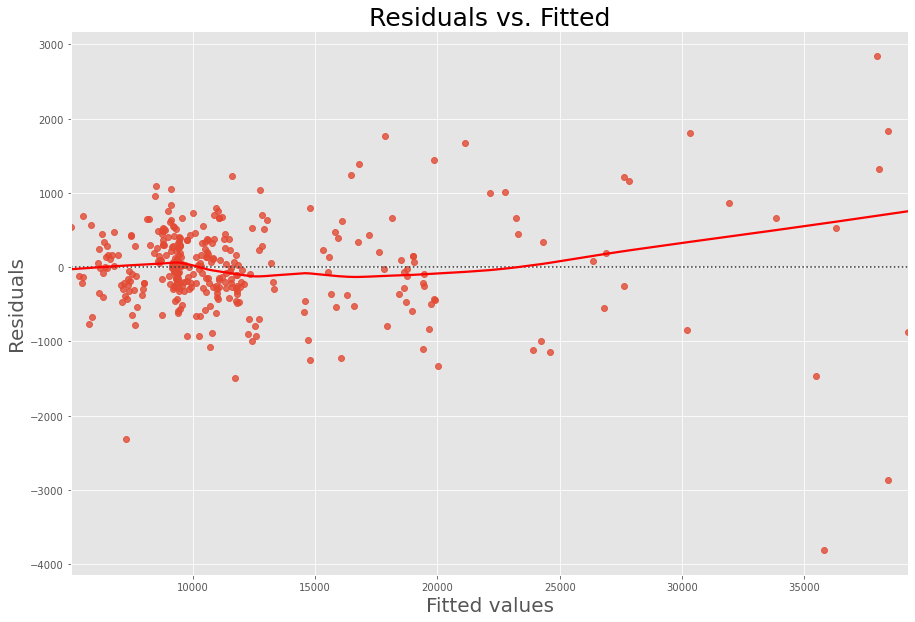

In [979]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.residplot(model6_fitted_y_values, df_btc_CCC_dummies['Close'], lowess = True, line_kws = {'color': 'red'})
ax.set_title('Residuals vs. Fitted', fontsize = 25)
ax.set_xlabel('Fitted values', fontsize = 20)
ax.set_ylabel('Residuals', fontsize = 20)

Text(0, 0.5, 'Standardized residuals')

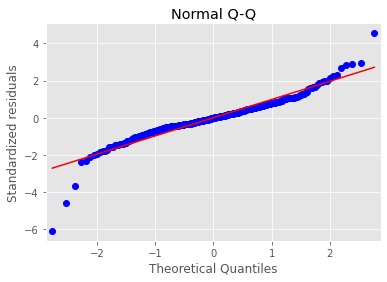

In [980]:
QQ = sgg.ProbPlot(model6_norm_resids)
qq_plot = QQ.qqplot(line = 's')
qq_plot.axes[0].set_title('Normal Q-Q')
qq_plot.axes[0].set_ylabel('Standardized residuals')

/home/jonathon/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'sqrt(abs(Standardized residuals))')

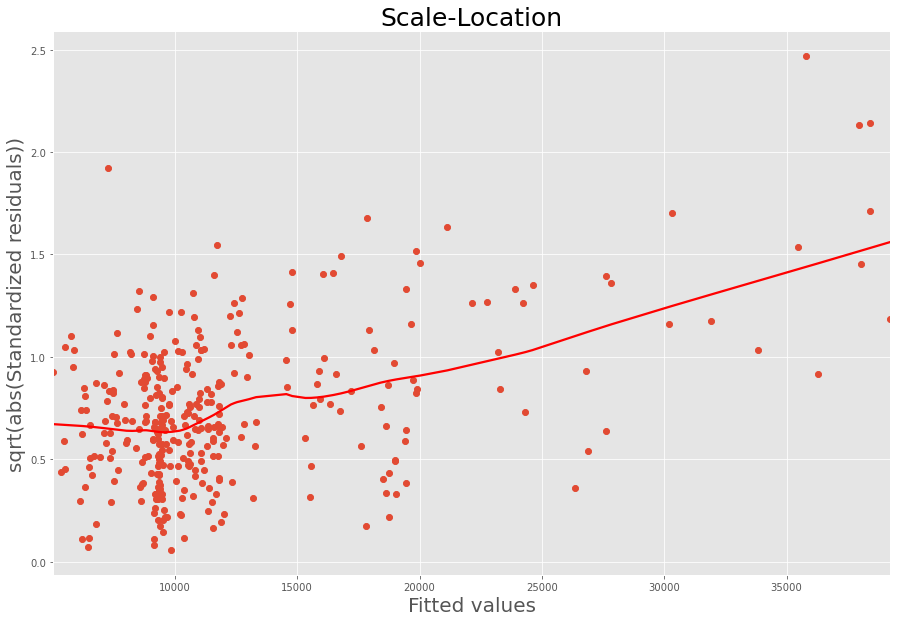

In [981]:
fig, ax = plt.subplots(figsize = (15, 10))
plt_scatter = plt.scatter(model6_fitted_y_values, model6_norm_resids_abs_sqrt)
plt_scale_location = sns.regplot(model6_fitted_y_values, model6_norm_resids_abs_sqrt, lowess = True, 
                                 line_kws = {'color': 'red'})
ax.set_title('Scale-Location', fontsize = 25)
ax.set_xlabel('Fitted values', fontsize = 20)
ax.set_ylabel('sqrt(abs(Standardized residuals))', fontsize = 20)
#constant variation and randomness of errors/residuals

/home/jonathon/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Standardized Residuals')

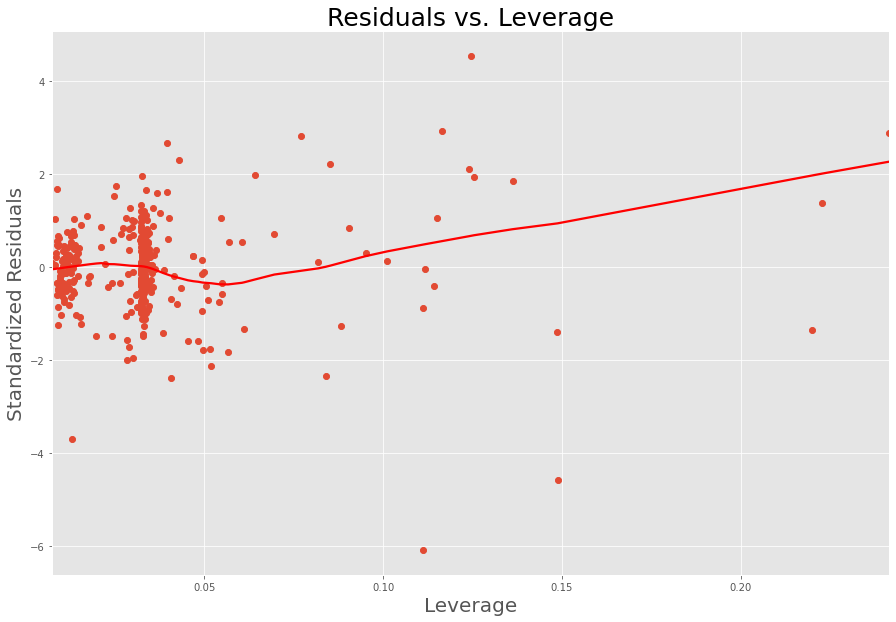

In [982]:
fig, ax = plt.subplots(figsize = (15, 10))
plt.scatter(model6_lev, model6_norm_resids)
sns.regplot(model6_lev, model6_norm_resids, lowess=True, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Leverage', fontsize = 25)
ax.set_xlabel('Leverage', fontsize = 20)
ax.set_ylabel('Standardized Residuals', fontsize = 20)

In [983]:
y_pred_6 = model6.predict(df_btc_CCC_dummies[['Relative_Time', 'Feb', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Jan', 'Close_LTC_lag_1', 'Close_XRP_lag_1', 'Close_ETH_lag_1']])

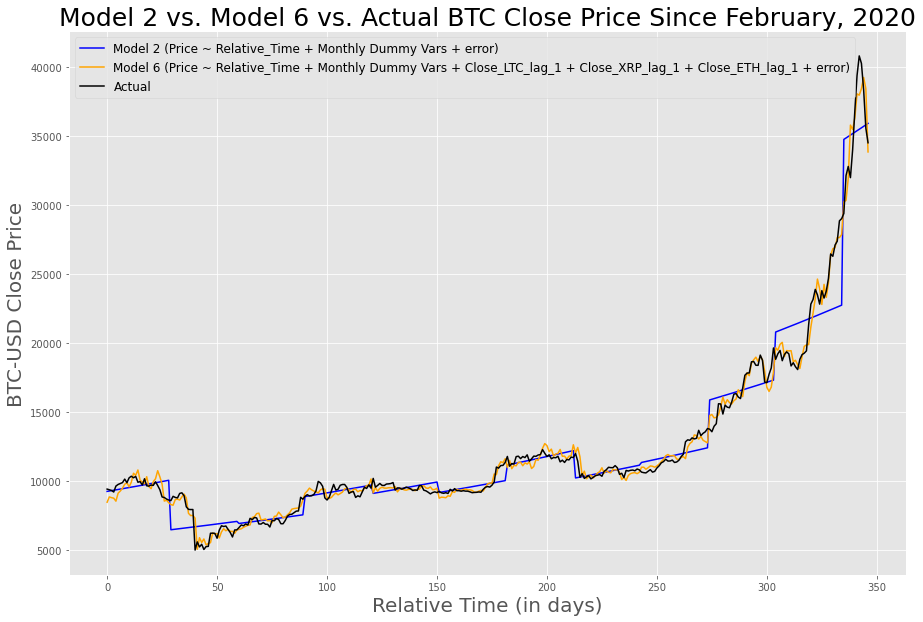

In [987]:
fig, ax = plt.subplots(figsize = (15, 10))
t = df_btc_baseline_dummies['Relative_Time']
actual = df_btc_baseline['Close']
ax.plot(t, e**y_pred_2, color = 'blue', label = 'Model 2 (Price ~ Relative_Time + Monthly Dummy Vars + error)')
ax.plot(t, y_pred_6, color = 'orange', label = 'Model 6 (Price ~ Relative_Time + Monthly Dummy Vars + Close_LTC_lag_1 + Close_XRP_lag_1 + Close_ETH_lag_1 + error)')
ax.plot(t, actual, color = 'black', label = 'Actual')
ax.set_title('Model 2 vs. Model 6 vs. Actual BTC Close Price Since February, 2020', fontsize = 25)
ax.set_xlabel('Relative Time (in days)', fontsize = 20)
ax.set_ylabel('BTC-USD Close Price', fontsize = 20)
plt.legend(fontsize = 12)

In [988]:
#instead, use 3-day MA as baseline model
df_btc_CCC_dummies['3_day_MA'] = float('NaN')

In [989]:
for i in range(3,len(df_btc_CCC_dummies)):
    df_btc_CCC_dummies['3_day_MA'][i] = df_btc_CCC_dummies['Close'][i-3:i].mean()

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [990]:
df_btc_CCC_dummies.columns.values

array(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Volume_Price', '10_Day_VWAP', 'Daily_Return', 'Biweekly_RS',
       'Biweekly_RSI', '12_day_EMA', '26_day_EMA', 'MACD', 'Signal',
       'Trend_Analysis_Close', 'Relative_Time', 'Month', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
       'Jan', 'Close_LTC_lag_1', 'Close_ETH_lag_1', 'Close_BNB_lag_1',
       'Close_BCH_lag_1', 'Close_XRP_lag_1', '3_day_MA'], dtype=object)

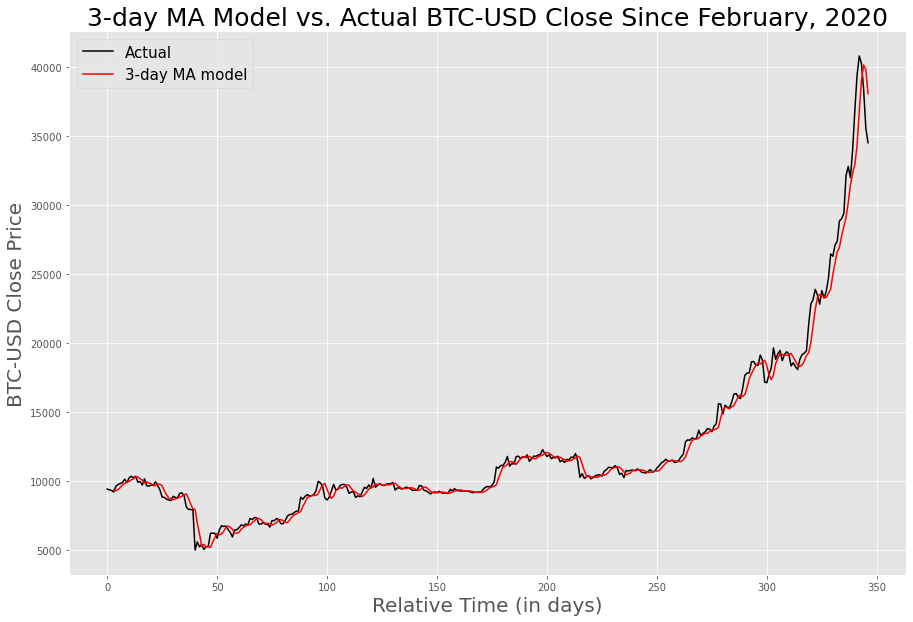

In [991]:
#plot 3-day MA vs. Actual
fig, ax = plt.subplots(figsize = (15, 10))
t = df_btc_CCC_dummies['Relative_Time']
actual = df_btc_CCC_dummies['Close']
ax.plot(t, actual, color = 'black', label = 'Actual')
ax.plot(t[3:], df_btc_CCC_dummies['3_day_MA'][3:], color = 'red', label = '3-day MA model')
ax.set_title('3-day MA Model vs. Actual BTC-USD Close Since February, 2020', fontsize = 25)
ax.set_xlabel('Relative Time (in days)', fontsize = 20)
ax.set_ylabel('BTC-USD Close Price', fontsize = 20)
plt.legend(fontsize = 15)

In [992]:
#calculate RMSE of 3-day MA model and other model...

In [993]:
df_btc_CCC_dummies[['pred_LR', 'Error_MA', 'Error_LR', 'Error_MA_sqr', 'Error_LR_sqr']] = float('NaN')

In [994]:
df_btc_CCC_dummies['Error_MA'] = df_btc_CCC_dummies['3_day_MA'] - df_btc_CCC_dummies['Close']

In [995]:
df_btc_CCC_dummies['Error_MA_sqr'] = df_btc_CCC_dummies['Error_MA']**2

In [996]:
for i in range(len(df_btc_CCC_dummies)):
    df_btc_CCC_dummies['pred_LR'][i] = y_pred_6[i]

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [997]:
df_btc_CCC_dummies['Error_LR'] = df_btc_CCC_dummies['pred_LR'] - df_btc_CCC_dummies['Close']

In [998]:
df_btc_CCC_dummies['Error_LR_sqr'] = df_btc_CCC_dummies['Error_LR']**2

In [999]:
RMSE_MA = np.sqrt(df_btc_CCC_dummies['Error_MA_sqr'].mean())
RMSE_MA

787.1493713096621

In [1000]:
RMSE_LR = np.sqrt(df_btc_CCC_dummies['Error_LR_sqr'].mean())
RMSE_LR

614.2563611925651

In [1001]:
#RMSE_LR < RMSE_MA, therefore multiple linear regressive model,
#i.e. Model 6, is an improvement on baseline model

In [1002]:
#ARIMA and other time-series models to implement...

In [1003]:
#MA, AR, then ARIMA modeling in that order...

In [1004]:
#first, detrend and deseasonalize the data...Model_2 is a pure trend/seasonal model of BTC price, 
#therefore subtract this model' predictions from actual prices
df_btc_CCC_dummies['Close_Detrended_Deseasonalized'] = df_btc_CCC_dummies['Close'] - e**y_pred_2

<AxesSubplot:title={'center':'BTC-USD Detrended/Deseasonalized Price Since February, 2020'}, xlabel='Relative_Time'>

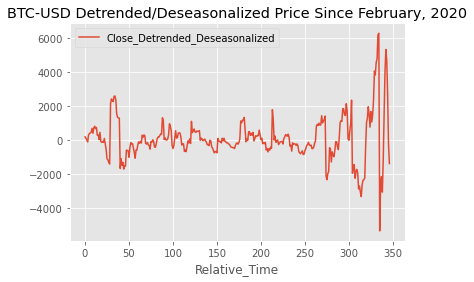

In [1005]:
df_btc_CCC_dummies.plot('Relative_Time', 'Close_Detrended_Deseasonalized', title = 'BTC-USD Detrended/Deseasonalized Price Since February, 2020')

In [1006]:
#perform Box-Cox Transformation on Close for BTC to remove variance issue from decomposition process

In [1007]:
BTC_transformed, lmda = stats.boxcox(df_btc_CCC_dummies['Close'])
print("Best lambda for transformation:", lmda)

Best lambda for transformation: -0.826075245656745


In [1008]:
BTC_t_series = pd.Series(data=BTC_transformed,
                              index=df_btc_CCC_dummies['Relative_Time'].values)
BTC_t_series.reset_index(inplace = True, drop = True)

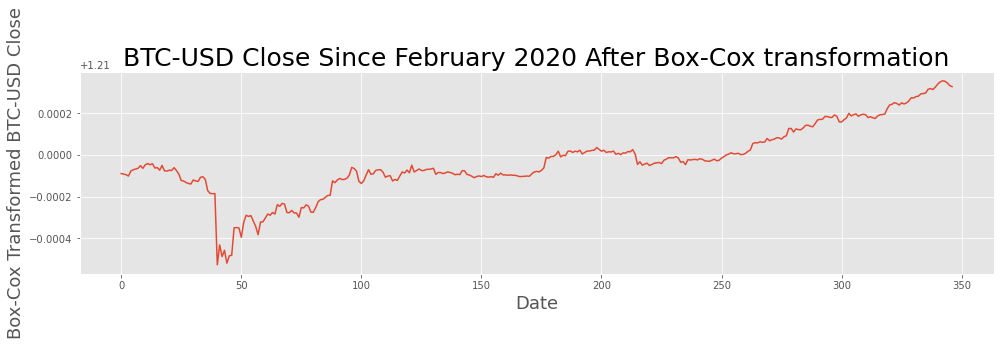

In [1009]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(BTC_t_series.index, BTC_t_series.values)
ax.set_title("BTC-USD Close Since February 2020 After Box-Cox transformation", fontsize = 25)
ax.set_ylabel('Box-Cox Transformed BTC-USD Close', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)
fig.tight_layout()
#less of steep exponential increase on 
#Box-Cox transformed BTC-USD

In [1010]:
df_btc_CCC_dummies['Close_transformed'] = BTC_transformed

In [1011]:
#Now detrend and deseasonalize BTC_transformed
model_transformed = ols('Close_transformed ~ Relative_Time + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Oct + Nov + Dec + Jan', data = df_btc_CCC_dummies).fit()
model_transformed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Close_transformed   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     299.0
Date:                Tue, 12 Jan 2021   Prob (F-statistic):          1.73e-170
Time:                        14:30:15   Log-Likelihood:                 2956.8
No. Observations:                 347   AIC:                            -5888.
Df Residuals:                     334   BIC:                            -5838.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.1168   5.09e-05    2.2e+04      0.000       1.117       1.117
Relative_Time  7.739e-07   3.04e-07      2.542      0.011    1.75e-07    1.37e-06
Feb               0.0933   5.45e-05   1711.366      0.000       0.093       0.093
Mar               0.0931   4.74e-05   1966.013      0.000       0.093       0.093
Apr               0.0929   3.84e-05   2420.710      0.000       0.093       0.093
May               0.0929   2.94e-05   3157.798      0.000       0.093       0.093
Jun               0.0930   2.07e-05   4500.745      0.000       0.093       0.093
Jul               0.0930   1.29e-05   7225.208      0.000       0.093       0.093
Aug               0.0930   8.51e-06   1.09e+04      0.000       0.093       0.093
Sep               0.0931   1.25e-05   7444.035      0.000       0.093       0.093
Oct               0.0930   2.04e-05   4565.300      0.000       0.093       0.093
Nov               0.0930    2.9e-05   3206.333      0.000       0.093       0.093
Dec               0.0931    3.8e-05   2449.592      0.000       0.093       0.093
Jan               0.0932   4.71e-05   1979.037      0.000       0.093       0.093
==============================================================================
Omnibus:                       65.036   Durbin-Watson:                   0.411
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              856.596
Skew:                           0.219   Prob(JB):                    9.83e-187
Kurtosis:                      10.685   Cond. No.                     1.15e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.04e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1012]:
df_btc_CCC_dummies['Close_transformed_detrended_deseasonalized'] = model_transformed.predict(df_btc_CCC_dummies[['Relative_Time', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']]) - df_btc_CCC_dummies['Close_transformed']

<AxesSubplot:xlabel='Relative_Time'>

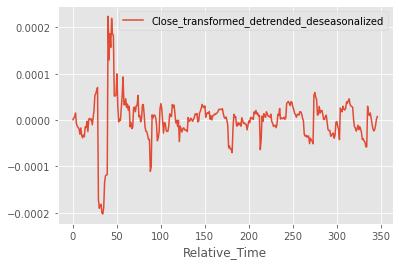

In [1013]:
df_btc_CCC_dummies.plot('Relative_Time', 'Close_transformed_detrended_deseasonalized')

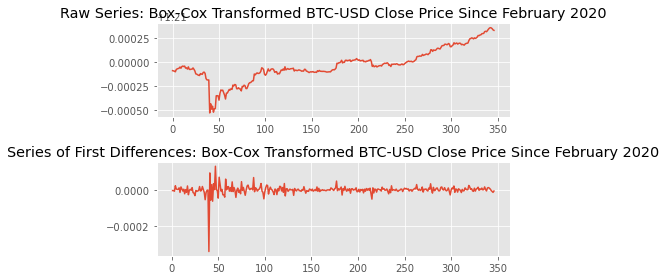

In [1111]:
#still variance issue!
#try difference series to detrend BTC-USD Close Price
fig, axs = plt.subplots(2, 1)
plot_series_and_difference(axs, BTC_t_series, 'Box-Cox Transformed BTC-USD Close Price Since February 2020')

In [1016]:
BTC_orig_t_series = pd.Series(data=df_btc_CCC_dummies['Close'].values,
                              index=df_btc_CCC_dummies['Relative_Time'].values)
BTC_orig_t_series.reset_index(inplace = True, drop = True)

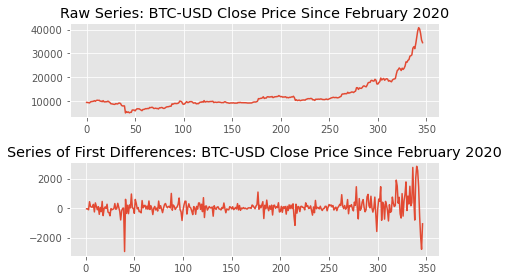

In [1017]:
fig, axs = plt.subplots(2, 1)
plot_series_and_difference(axs, BTC_orig_t_series, 'BTC-USD Close Price Since February 2020')

Variance still isn't stable, but much better than just differencing original values: try taking log of BTC-USD Close price, then applying Box-Cox transformation and differencing, compare and choose best result!

In [1041]:
df_btc_CCC_dummies['log_10(Close)'] = np.log10(df_btc_CCC_dummies['Close'])

<AxesSubplot:xlabel='Relative_Time'>

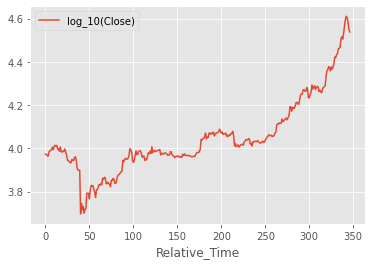

In [1042]:
df_btc_CCC_dummies.plot('Relative_Time', 'log_10(Close)')

In [1043]:
df_btc_CCC_dummies['ln(Close)'] = np.log(df_btc_CCC_dummies['Close'])

<AxesSubplot:xlabel='Relative_Time'>

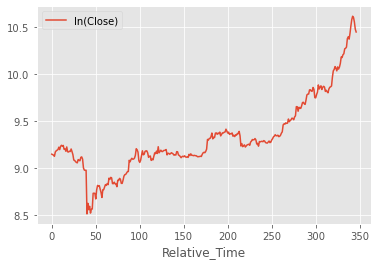

In [1044]:
df_btc_CCC_dummies.plot('Relative_Time', 'ln(Close)')

In [1045]:
#cannot remove minor variance issue even with log10() or ln() 
#of Close as is evident by visualizations, 
#so the corresponding time segment of the prediction 
#with high variance will be inaccurate...

In [1047]:
#ADF p-value << 0.05!
test = sm.tsa.stattools.adfuller(BTC_t_series.diff()[1:])
print("ADF p-value for Differenced Box-Cox series: {0}".format(test[1]))

ADF p-value for Differenced Box-Cox series: 2.8173468528616666e-11


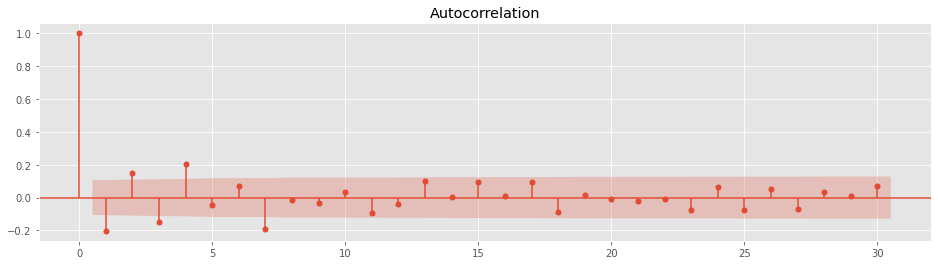

In [1048]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sm.graphics.tsa.plot_acf(BTC_t_series.diff()[1:], lags=30, ax=ax)

In [1049]:
#MA modeling, 4 additional lags is statistically significant based on ACF plot
model_ma = ARIMA(BTC_t_series, order=(0, 1, 4))
model_ma.fit()

/home/jonathon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/jonathon/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to conver

In [1050]:
pred_ma = model_ma.predict(BTC_t_series)

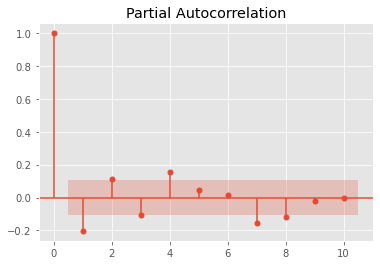

In [1051]:
_ = sm.graphics.tsa.plot_pacf(BTC_t_series.diff()[1:], lags=10)

In [1052]:
#AR modeling, 4 additional lags is statistically significant based on PACF plot
model_ar = ARIMA(BTC_t_series, order=(4, 1, 0))
model_ar.fit()

/home/jonathon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [1053]:
pred_ar = model_ar.predict(BTC_t_series)

In [1054]:
#ARIMA modeling
model_arima = ARIMA(BTC_t_series, order = (4, 1, 4))
model_arima.fit()

/home/jonathon/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/jonathon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

 

In [1055]:
pred_arima = model_arima.predict(BTC_t_series)

In [1056]:
#ARIMA model with auto_arima function under pmdarima library
model_auto_arima = pm.auto_arima(BTC_t_series, seasonal=False)

In [1057]:
model_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  347
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3179.894
Date:                Tue, 12 Jan 2021   AIC                          -6351.789
Time:                        15:40:26   BIC                          -6336.403
Sample:                             0   HQIC                         -6345.662
                                - 347                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.357e-06   3.04e-06      0.446      0.656   -4.61e-06    7.32e-06
ar.L1         -0.8236   8.44e-11  -9.76e+09      0.000      -0.824      -0.824
ma.L1          0.6553   2.72e-11   2.41e+10      0.000       0.655       0.655
sigma2      6.114e-10   5.98e-11     10.224      0.000    4.94e-10    7.29e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):            161554.06
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.07   Skew:                            -7.29
Prob(H) (two-sided):                  0.00   Kurtosis:                       107.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+25. Standard errors may be unstable.
"""

In [1058]:
# make forecast
forecasts = model_auto_arima.predict(1)  
#predict N = 1 steps into the future

/home/jonathon/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


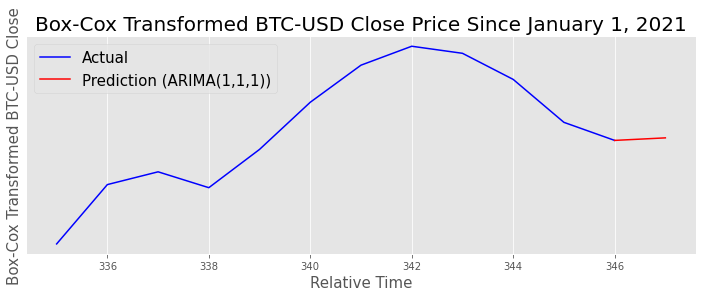

In [1059]:
# Visualize the forecast
fig, ax = plt.subplots(figsize = (12,4))
ax.plot(BTC_t_series.index.values[335:], BTC_t_series.values[335:], c='blue', label = 'Actual')
ax.plot([346, 347], [BTC_t_series[346], forecasts], c='red', label = 'Prediction (ARIMA(1,1,1))')
ax.set_title('Box-Cox Transformed BTC-USD Close Price Since January 1, 2021', fontsize = 20)
ax.set_yticks([])
ax.set_ylabel('Box-Cox Transformed BTC-USD Close', fontsize = 15)
ax.set_xlabel('Relative Time', fontsize = 15)
ax.legend(fontsize = 15)

In [1040]:
models_arima = []
for i in range(1,31):
    models_arima.append(pm.auto_arima(BTC_t_series, seasonal = True, m = i))
for model in models_arima:
    print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  347
Model:               SARIMAX(1, 1, 1)   Log Likelihood                3179.894
Date:                Tue, 12 Jan 2021   AIC                          -6351.789
Time:                        15:40:09   BIC                          -6336.403
Sample:                             0   HQIC                         -6345.662
                                - 347                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.357e-06   3.04e-06      0.446      0.656   -4.61e-06    7.32e-06
ar.L1         -0.8236   8.44e-11  -9.76e+09      0.000      -0.824      -0.824
ma.L1          0.6553   2.72e-11   2.41e+10      0.0

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  347
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 13)   Log Likelihood                3182.172
Date:                             Tue, 12 Jan 2021   AIC                          -6354.345
Time:                                     15:40:09   BIC                          -6335.113
Sample:                                          0   HQIC                         -6346.686
                                             - 347                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.28e-06      3e-06      0.427      0.670    -4.6e-06    7.16e-06
ar.L1         -0.8236   8.5

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  347
Model:               SARIMAX(4, 1, 0)   Log Likelihood                3182.145
Date:                Tue, 12 Jan 2021   AIC                          -6352.291
Time:                        15:40:09   BIC                          -6329.212
Sample:                             0   HQIC                         -6343.101
                                - 347                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.127e-06   1.79e-06      0.630      0.529   -2.38e-06    4.64e-06
ar.L1         -0.1515      1e-11  -1.51e+10      0.000      -0.151      -0.151
ar.L2          0.0787   9.61e-12   8.18e+09      0.0

In [722]:
#best model via "AIC": 
#SARIMAX(order = (1,1,1), seasonal_order = (1,0,[],7))
#best model via "Log Likelihood": 
#SARIMAX(order = (1,1,0))

In [1060]:
log_likelihood_model = SARIMAX(BTC_t_series, order = (1, 1, 1)).fit()

/home/jonathon/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [1061]:
weekly_model = SARIMAX(BTC_t_series, order = (1, 1, 1), seasonal_order = (1, 0, [], 7)).fit()

/home/jonathon/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


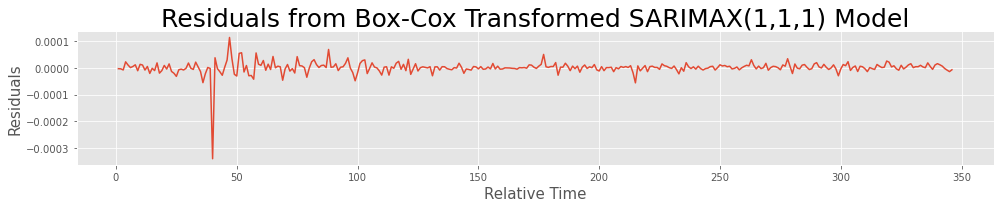

In [1062]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(log_likelihood_model.resid.index[1:], log_likelihood_model.resid[1:])
ax.set_title("Residuals from Box-Cox Transformed SARIMAX(1,1,1) Model", fontsize = 25)
ax.set_xlabel('Relative Time', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
plt.tight_layout()

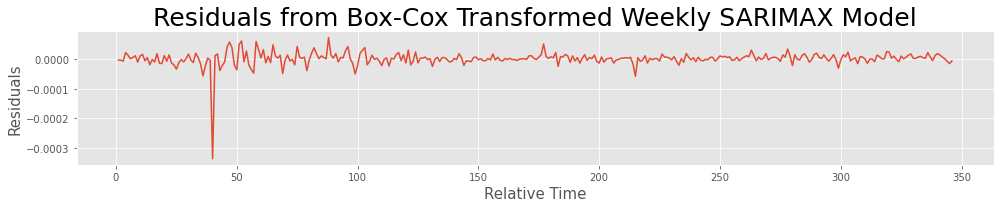

In [1063]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(weekly_model.resid.index[1:], weekly_model.resid[1:])
ax.set_title("Residuals from Box-Cox Transformed Weekly SARIMAX Model", fontsize = 25)
ax.set_xlabel('Relative Time', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
plt.tight_layout()

In [1064]:
#residuals = actual - predicted, 
#therefore predicted = actual - residuals

In [1065]:
df_btc_CCC_dummies[['ARIMA_weekly_pred', 'ARIMA_pred']] = float('NaN')

In [1066]:
for i in range(1,len(df_btc_CCC_dummies)):
    df_btc_CCC_dummies['ARIMA_weekly_pred'][i] = df_btc_CCC_dummies['Close_transformed'][i] - weekly_model.resid[i]
    df_btc_CCC_dummies['ARIMA_pred'][i] = df_btc_CCC_dummies['Close_transformed'][i] - log_likelihood_model.resid[i]

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1067]:
df_btc_CCC_dummies[['ARIMA_weekly_pred_untransf', 'ARIMA_pred_untransf']] = float('NaN')

In [1068]:
for i in range(1, len(df_btc_CCC_dummies)):
    df_btc_CCC_dummies['ARIMA_weekly_pred_untransf'][i] = inv_boxcox(df_btc_CCC_dummies['ARIMA_weekly_pred'][i], -0.826075245656745)
    df_btc_CCC_dummies['ARIMA_pred_untransf'][i] = inv_boxcox(df_btc_CCC_dummies['ARIMA_pred'][i], -0.826075245656745)

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1069]:
df_btc_CCC_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 347 entries, 2020-02-01 to 2021-01-12
Data columns (total 50 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Open                                        347 non-null    float64
 1   High                                        347 non-null    float64
 2   Low                                         347 non-null    float64
 3   Close                                       347 non-null    float64
 4   Adj Close                                   347 non-null    float64
 5   Volume                                      347 non-null    int64  
 6   Volume_Price                                347 non-null    float64
 7   10_Day_VWAP                                 347 non-null    float64
 8   Daily_Return                                347 non-null    float64
 9   Biweekly_RS                                 347 non-null    float64
 10  Biw

In [1070]:
df_btc_CCC_dummies[['Error_ARIMA_weekly', 'Error_ARIMA', 'Error_ARIMA_weekly_sqr', 'Error_ARIMA_sqr']] = float('NaN')

In [1071]:
for i in range(1, len(df_btc_CCC_dummies)):
    df_btc_CCC_dummies['Error_ARIMA_weekly'][i] = df_btc_CCC_dummies['Close'][i] - df_btc_CCC_dummies['ARIMA_weekly_pred_untransf'][i]
    df_btc_CCC_dummies['Error_ARIMA'][i] = df_btc_CCC_dummies['Close'][i] - df_btc_CCC_dummies['ARIMA_pred_untransf'][i]
    df_btc_CCC_dummies['Error_ARIMA_weekly_sqr'][i] = df_btc_CCC_dummies['Error_ARIMA_weekly'][i]**2
    df_btc_CCC_dummies['Error_ARIMA_sqr'][i] = df_btc_CCC_dummies['Error_ARIMA'][i]**2

/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jonathon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [1072]:
RMSE_ARIMA_weekly = np.sqrt(df_btc_CCC_dummies['Error_ARIMA_weekly_sqr'][1:].mean())

In [1073]:
RMSE_ARIMA = np.sqrt(df_btc_CCC_dummies['Error_ARIMA_sqr'][1:].mean())

In [1074]:
f'RMSE_MA: {RMSE_MA}, RMSE_LR: {RMSE_LR}, RMSE_ARIMA_weekly" {RMSE_ARIMA_weekly}, RMSE_ARIMA: {RMSE_ARIMA}'

'RMSE_MA: 787.1493713096621, RMSE_LR: 614.2563611925651, RMSE_ARIMA_weekly" 610.1683540048696, RMSE_ARIMA: 571.8795179222597'

In [1075]:
#RMSE_ARIMA is lowest RMSE and best model thus far

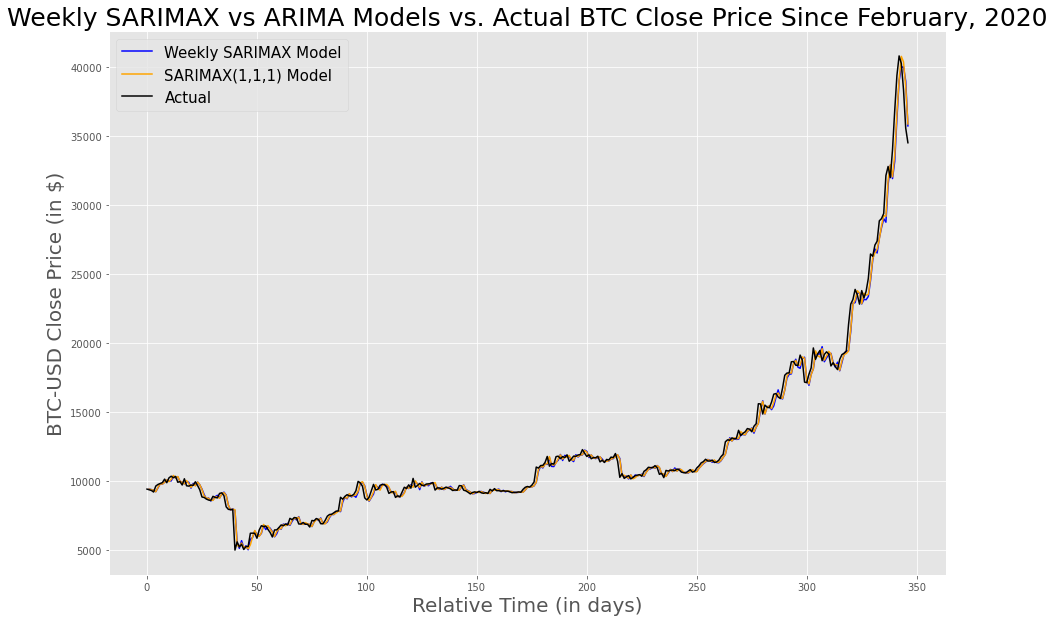

In [1076]:
#plot ARIMA models against Actual
fig, ax = plt.subplots(figsize = (15, 10))
t = df_btc_CCC_dummies['Relative_Time']
actual = df_btc_CCC_dummies['Close']
ax.plot(t[1:], df_btc_CCC_dummies['ARIMA_weekly_pred_untransf'][1:], color = 'blue', label = 'Weekly SARIMAX Model')
ax.plot(t[1:], df_btc_CCC_dummies['ARIMA_pred_untransf'][1:], color = 'orange', label = 'SARIMAX(1,1,1) Model')
ax.plot(t, actual, color = 'black', label = 'Actual')
ax.set_title('Weekly SARIMAX vs ARIMA Models vs. Actual BTC Close Price Since February, 2020', fontsize = 25)
ax.set_xlabel('Relative Time (in days)', fontsize = 20)
ax.set_ylabel('BTC-USD Close Price (in $)', fontsize = 20)
plt.legend(fontsize = 15)

In [1077]:
pred_weekly = weekly_model.predict(347).values

In [1079]:
pred_log_likelihood = log_likelihood_model.predict(347).values

In [1082]:
pred_weekly_untransf = inv_boxcox(pred_weekly, -0.826075245656745)[0]

In [1083]:
pred_ARIMA_untransf = inv_boxcox(pred_log_likelihood, -0.826075245656745)[0]

In [1085]:
f'Weekly SARIMAX next day prediction: {pred_weekly_untransf}, SARIMAX(1,1,1) next day prediction: {pred_ARIMA_untransf}.'

'Weekly SARIMAX next day prediction: 33953.466017099454, SARIMAX(1,1,1) next day prediction: 34487.828618792606.'

In [1086]:
df_pred_model6 = pd.DataFrame(data = {'Relative_Time': 339, 'Feb': 0, 'Jun': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Jan': 1, 'Close_LTC_lag_1': df_btc_CCC_dummies['Close_LTC_lag_1'][-1], 'Close_XRP_lag_1': df_btc_CCC_dummies['Close_XRP_lag_1'][-1], 'Close_ETH_lag_1': df_btc_CCC_dummies['Close_ETH_lag_1'][-1]}, index = [0]) 

In [1087]:
df_pred_model6

Relative_Time  Feb  Jun  Aug  Sep  Oct  Nov  Jan  Close_LTC_lag_1  \
0            339    0    0    0    0    0    0    1       139.252228   

   Close_XRP_lag_1  Close_ETH_lag_1  
0         0.288905      1090.145386

In [1088]:
model6_pred = model6.predict(df_pred_model6[['Relative_Time', 'Feb', 'Jun', 'Aug', 'Sep', 'Oct', 'Nov', 'Jan', 'Close_LTC_lag_1', 'Close_XRP_lag_1', 'Close_ETH_lag_1']]).values[0]

In [1089]:
MA_pred = df_btc_CCC_dummies['Close'][-3:].mean()

In [1090]:
f'3-day MA next day prediction: {MA_pred}, Multiple Linear Regressive Model next day prediction: {model6_pred}.'

'3-day MA next day prediction: 36141.643229, Multiple Linear Regressive Model next day prediction: 30641.944419335618.'

In [1091]:
'BTC-USD Actual Close Price on next day (13JAN21): TBD'

'BTC-USD Actual Close Price on next day (13JAN21): TBD'

In [1092]:
#incorporate coin ranking and macroeconomic factors
#into LSTM model in future after project?

In [1093]:
model_lstm = keras.Sequential()

In [1094]:
model_lstm.add(keras.layers.LSTM(32, input_shape = (100, 1), return_sequences = True))
model_lstm.add(keras.layers.LSTM(32, return_sequences = False))
model_lstm.add(keras.layers.Dense(1, activation = 'linear'))
model_lstm.compile(optimizer = 'rmsprop', loss = 'mse')

In [1095]:
model_lstm.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 100, 32)           4352      
_________________________________________________________________
lstm_35 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [1110]:
x_input_lstm, y_input_lstm = windowize_data(df_btc['Close'].values, 100)

In [1098]:
x_input_lstm.shape

(2210, 100, 1)

In [1099]:
y_input_lstm.shape

(2210,)

In [1100]:
f'Goal is to produce LSTM model with MSE < MSE_ARIMA = {RMSE_ARIMA**2}.'

'Goal is to produce LSTM model with MSE < MSE_ARIMA = 327046.1830189961.'

In [1101]:
model_lstm.fit(x_input_lstm, y_input_lstm, batch_size = 32, epochs = 10)

Epoch 1/10
2210/2210 [==============================] - 33s 15ms/sample - loss: 56431876.3222
Epoch 2/10
2210/2210 [==============================] - 26s 12ms/sample - loss: 56382889.9041
Epoch 3/10
2210/2210 [==============================] - 25s 11ms/sample - loss: 56359038.1665
Epoch 4/10
2210/2210 [==============================] - 27s 12ms/sample - loss: 56334884.2063
Epoch 5/10
2210/2210 [==============================] - 25s 11ms/sample - loss: 56311034.5629
Epoch 6/10
2210/2210 [==============================] - 31s 14ms/sample - loss: 56287219.7249
Epoch 7/10
2210/2210 [==============================] - 27s 12ms/sample - loss: 56263182.4363
Epoch 8/10
2210/2210 [==============================] - 30s 14ms/sample - loss: 56239200.5611
Epoch 9/10
2210/2210 [==============================] - 28s 12ms/sample - loss: 56215483.0335
Epoch 10/10
2210/2210 [==============================] - 28s 13ms/sample - loss: 56191442.5955


In [1108]:
#will need more sufficient data to fit an LSTM model to, 
#i.e. much more granular time-series data for BTC-USD prices
#to avoid running thousands of epochs

In [1112]:
# we set which pair we want to retrieve data for
pair = "BTC/USD"
fetch_daily_data(symbol=pair)

In [1113]:
df_btc_minute_gran = pd.read_csv('Coinbase_BTCUSD_dailydata.csv')

In [1114]:
df_btc_minute_gran.head(10)

unix       low      high      open     close         volume  \
0  1610409600  32500.00  36604.51  35456.89  33850.00   46623.126932   
1  1610323200  30100.00  38273.88  38168.89  35452.59  102503.156728   
2  1610236800  34444.00  41452.12  40257.43  38171.57   43736.570316   
3  1610150400  38800.00  41406.94  40642.15  40257.43   27152.971029   
4  1610064000  36565.08  41986.37  39510.55  40665.15   48522.484903   
5  1609977600  36200.00  40425.00  36859.26  39505.56   50346.305691   
6  1609891200  33352.54  37000.00  34043.91  36859.26   45744.103200   
7  1609804800  29891.13  34499.67  32020.22  34030.64   42282.569200   
8  1609718400  27678.00  33666.99  33082.84  32019.99   46045.389685   
9  1609632000  32008.62  34810.00  32222.88  33080.66   36951.716506   

         date      vol_fiat  
0  2021-01-12  1.578193e+09  
1  2021-01-11  3.634002e+09  
2  2021-01-10  1.669494e+09  
3  2021-01-09  1.093109e+09  
4  2021-01-08  1.973174e+09  
5  2021-01-07  1.988959e+09  
6  2021-01-06  1.686094e+09  
7  2021-01-05  1.438903e+09  
8  2021-01-04  1.474373e+09  
9  2021-01-03  1.222387e+09

In [1115]:
#the hope was in the Coinbase url, i.e. 86400, 
#which is equal to 60 * 60 * 24 = 86400, 
#would populate data with granularity in the minutes, 
#however this did not occur, 
#LSTM model will only be effective with more granular data, 
#so next steps following this project would be to 
#locate more granular pricing data of BTC-USD